# Avito Demand Prediction Machine Learning Competition

**Instructor: Johnston Patrick Hall**

**Team Member:**

* Hsia, Pei-Hsuan
* Liu, Miki
* Xing, Guangyu
* Zeng, Jiwei 

**Finish Date**: *June 27th, 2018*

## About the Project

**Avito.ru** is the most popular classifieds site in Russia and is the third biggest classifieds site in the world after Craigslist and the Chinese website 58.com. In December 2016, it had more than 35 million unique monthly visitors. On average, Avito.ru's users post more than 500,000 new ads daily and the overall ads are about 30 million active listings.

https://www.kaggle.com/c/avito-demand-prediction

When selling used goods online, a combination of tiny, nuanced details in a product description can make a big difference in drumming up interest. And, even with an optimized product listing, demand for a product may simply not exist–frustrating sellers who may have over-invested in marketing.

**Target:**
In this competition, Avito is challenging us to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts. With this information, Avito can inform sellers on how to best optimize their listing and provide some indication of how much interest they should realistically expect to receive.

## About the Notebook

One more exciting competition ahead and this involves both NLP (text data in Russian) and Image data along with numerical.
In this notebook, we will take a look at **feature extraction**, **text mining** and **Gradient Boosting Machine** models training.

**Steps:**
1. *Import data sets*
2. *Translate columns in Russian into ones in English or substitute Cylliric Alphabets with Roman Alphabets*
4. *Fill null values*
5. *Target Encoding*
6. *Feature extraction with text columns*
7. *TF-IDF* 
8. *Wordbatch*
9. *Image Feature extraction with Keras*
3. *Split the Training datasets into Training and Validation*
10. *Train model with Light GBM*
11. *Train model with XGBoost*
12. *Submit results and select model*

### Import Packages

In [1]:
## Modules for basic data processing
import pandas as pd
import datetime as dt
import numpy as np
import math
import os
from googletrans import Translator
import time
start_time = time.time()
import gc
import matplotlib.pyplot as plt
from numpy import loadtxt

In [2]:
## Modules for text processing
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import wordbatch
from wordbatch.extractors import WordBag
from wordbatch.models import FM_FTRL
from nltk.corpus import stopwords 

In [3]:
## Modules for image processing
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
## Modules for model training preparation and validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [5]:
## Light GBM Model Training
import lightgbm as lgb

In [6]:
## XGboost Model Training
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

### Read Data Files

In [7]:
kaggle_path = '.kaggle/competitions/avito-demand-prediction/'

In [8]:
train = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'train.csv'))
test = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'test.csv'))
periods_train = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'periods_train.csv'))
periods_test = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'periods_test.csv'))
## We only need four columns in train_active and test-active datasets
train_active = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'train_active.csv'), usecols = ['item_id', 'user_id', 'price', 'item_seq_number'])
test_active = pd.read_csv(os.path.join(os.getcwd(), kaggle_path + 'test_active.csv'), usecols = ['item_id', 'user_id', 'price', 'item_seq_number'])

In [9]:
whole_data = pd.concat([train, test], sort = False)

In [10]:
periods = pd.concat([periods_train, periods_test], sort = False)

In [11]:
active = pd.concat([train_active, test_active], sort = False)

### Translation

For some columns are in Russian (Region, City, Description ... ), we will translate the columns into English or substitute Cyrillic Alphabets with Roman Alphabets in case that some text processing packages don't support Cyrillic letters.

In [12]:
## Define a function to distint the list in a column and translate Russian to English.
def list_translate(column):
    words_list = whole_data[column].unique()
    translator = Translator()
    words_list_dict = {}
    for word in words_list:
        try:
            word_trans = translator.translate(word, dest = 'en').text
            words_list_dict[word] = word_trans
        except ValueError:
            words_list_dict[word] = word
    return words_list_dict

In [13]:
## Define a function to create new columns.
def col_translate(column):
    list_trans = list_translate(column)
    train[column + '_en'] = train[column].apply(lambda x: list_trans[x])
    test[column + '_en'] = test[column].apply(lambda x: list_trans[x])

In [14]:
## Create a list of columns that should be translated.
col_trans = ['category_name', 'city', 'parent_category_name', 'region']

In [15]:
## Translate the columns and create new columns.
for col in col_trans:
    col_translate(col)

In [16]:
## Create a dictionary of Cyrillic Alphabet with correspondin Roman Alphabet
symbols = (u"АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя",
           u"ABVGDEEZZIIKLMNOPRSTUFKSCSSEYBEUAabvgdeezziiklmnoprstufkscsceybeua")
tr = {ord(a): ord(b) for a, b in zip(*symbols)}

In [17]:
## Define a function to substitute Cyrillic Alphabet with correspondin Roman Alphabet
def cyrillic2latin(input):
    try:
        output = input.translate(tr)
    except AttributeError:
        output = input
    return output

In [18]:
## Create list of columns in which Cyrillic Alphabets should be substituted with Ranman Alphabets
col_sub = ['param_1', 'param_2', 'param_3', 'title', 'description']

In [19]:
## Run the subtitution function
for col in col_sub:
    train[col + '_new'] = train[col].apply(lambda x: cyrillic2latin(x))
    test[col + '_new'] = test[col].apply(lambda x: cyrillic2latin(x))

### Combine datasets

In [20]:
y = train['deal_probability']
train = train.drop('deal_probability', axis = 1)

In [21]:
train['train'] = 1
test['train'] = 0

In [22]:
## We concatenate train and test datasets.
whole_data = pd.concat([train, test])

### Fill null values

In [23]:
## Fill null valid with 0 in 'image_top_1' coloumn.
whole_data['image_top_1'] = whole_data['image_top_1'].fillna(-999)

In [24]:
whole_data["price"] = np.log(whole_data["price"]+0.001)

In [25]:
## Fill null valid with median in 'price' coloumn.
whole_data['price'] = whole_data['price'].fillna(whole_data['price'].mean())

In [26]:
## Extract weekday from activation_date
whole_data['activation_date'] = pd.to_datetime(whole_data['activation_date'])
whole_data['activation_weekday'] = whole_data['activation_date'].apply(lambda x: x.weekday())

### Extract information from Periods & Active tables

In [27]:
## Create list of columns of tree dates
date_list = ['activation_date', 'date_from', 'date_to']

In [28]:
## Transform date columns into date type
for col in date_list:
    periods[col] = pd.to_datetime(periods[col])

In [29]:
## Calculte the date difference between 'date_from' and 'activation_date'.
periods['date_diff1'] = (periods['date_from'] - periods['activation_date']).dt.days

In [30]:
## Calculte the date difference between 'date_to' and 'date_from'.
periods['date_diff2'] = (periods['date_to'] - periods['date_from']).dt.days

In [31]:
## Drop the columns we won't use any more.
periods = periods.drop(['activation_date', 'date_from', 'date_to'], axis = 1)

In [32]:
## Join the information from periods tables into active datasets
active = active.merge(periods, left_on = 'item_id', right_on = 'item_id', how = 'left')

In [33]:
## Count number of users in the active datasets
supp = active.groupby('user_id').count()['item_id'].reset_index()
supp.columns = ['user_id', 'count']

In [34]:
active = active.drop('item_id', axis = 1)

In [35]:
## Calculate maximum of price, item_sep_number, date_diff1 and date_diff2
maxi = active.groupby('user_id').max().reset_index()
maxi.columns = ['user_id', 'price_max', 'item_seq_number_max', 'date_diff1_max', 'date_diff2_max']
supp = supp.merge(maxi, left_on = 'user_id', right_on = 'user_id', how = 'left')

In [36]:
## Calculate minimum of price, item_sep_number, date_diff1 and date_diff2
mini = active.groupby('user_id').min().reset_index()
mini.columns = ['user_id', 'price_min', 'item_seq_number_min', 'date_diff1_min', 'date_diff2_min']
supp = supp.merge(mini, left_on = 'user_id', right_on = 'user_id', how = 'left')

In [37]:
## Calculate mean of price, item_sep_number, date_diff1 and date_diff2
mean = active.groupby('user_id').mean().reset_index()
mean.columns = ['user_id', 'price_mean', 'item_seq_number_mean', 'date_diff1_mean', 'date_diff2_mean']
supp = supp.merge(mean, left_on = 'user_id', right_on = 'user_id', how = 'left')

In [38]:
## Join the supplemental information from active and period tables into original datasets
whole_data = whole_data.merge(supp, left_on = 'user_id', right_on = 'user_id', how = 'left')

In [39]:
## Create a list of new columns
col_fillna = ['count','price_max','item_seq_number_max','date_diff1_max','date_diff2_max','price_min','item_seq_number_min','date_diff1_min','date_diff2_min','price_mean','item_seq_number_mean','date_diff1_mean','date_diff2_mean']

In [40]:
## Fill null values in new columns with medians
for col in col_fillna:
    whole_data[col] = whole_data[col].fillna(whole_data[col].dropna().median())

### Feature extraction with text columns

In [41]:
## Combine param_1, param_2 and param_3
whole_data['all_param'] = whole_data["param_1_new"] + " " + whole_data["param_2_new"] + " " + whole_data["param_3_new"]

In [42]:
## Create a list of test columns
text_col = ["all_param", "title_new", "description_new"]

In [43]:
## Feature extraction
for col in text_col:
    whole_data[col] = whole_data[col].astype(str)
    whole_data[col] = whole_data[col].astype(str).fillna('missing')
    whole_data[col] = whole_data[col].str.lower()
    whole_data[col+'_n_chars'] = whole_data[col].apply(len) # Count number of Characters
    whole_data[col+'_n_words'] = whole_data[col].apply(lambda x: len(x.split())) # Count number of Words
    # Count Unique Words
    whole_data[col+'_n_uniq_words'] = whole_data[col].apply(lambda x: len(set(w for w in x.split())))
    # Unique words to Word count Ratio
    whole_data[col+'_words_vs_unique'] = whole_data[col+'_n_uniq_words'] / whole_data[col+'_n_words']*100  

### Target encoding

In [44]:
## Create a list of columns that need target encoding.
col_tar = ['category_name_en', 'city_en', 'parent_category_name_en', 'region_en', 'user_type','param_1', 'param_2', 'param_3',"image_top_1"]

In [45]:
## Do target encoding
# Encoder:
lbl = preprocessing.LabelEncoder()
for col in col_tar:
    whole_data[col] = whole_data[col].fillna('Unknown')
    whole_data[col+ '_encode'] = lbl.fit_transform(whole_data[col].astype(str))

### TF_IDF

In [46]:
n_features = [500, 100, 40, 100]

In [47]:
import nltk

In [48]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
russian_stop = set(stopwords.words('russian'))

In [50]:
for c_i, c in tqdm(enumerate(text_col)):
    tfidf = TfidfVectorizer(max_features=n_features[c_i], min_df=3,stop_words=russian_stop)
    tfidf.fit(whole_data[c])
    tfidf_train = np.array(tfidf.transform(whole_data[c]).todense(), dtype=np.float16)

    for i in range(n_features[c_i]):
        try:
            whole_data[c + '_tfidf_' + str(i)] = tfidf_train[:, i]
        except (KeyError, IndexError):
            continue

3it [03:15, 65.01s/it]


### Wordbatch

**Wordbatch** produces parallel feature extraction from raw text data for uses such as deep learning and text analytics. The most basic use for Wordbatch is as a drop-in replacement for the more basic non-parallelized extraction available in toolkits such as **Scikit-learn, TfLearn and Keras**. Wordbatch additionally provides customizable preprocessing and feature extractors that improve predictive performance.

Unlike text preprocessing in these toolkits that either deal with text as a single batch or as a stream, Wordbatch works best with large minibatches of text data. Wordbatch internally stores per-batch statistics of the data, and applies these for uses such as dictionary selection, spelling correction, and online IDF weighting. The larger the batches, the better choices Wordbatch can make in extracting features.

In [51]:
X_train = whole_data[whole_data['train'] == 1]
X_test = whole_data[whole_data['train'] == 0]

In [52]:
## Set wordbatch parameters
wb = wordbatch.WordBatch(None, extractor=(WordBag, {"hash_ngrams": 2,
                                                              "hash_ngrams_weights": [1.0, 1.0],
                                                              "hash_size": 2 ** 28,
                                                              "norm": "l2",
                                                              "tf": 1.0,
                                                              "idf": None}), procs=8)
wb.dictionary_freeze = True

In [53]:
X_all_param_train = wb.fit_transform(X_train['all_param'])
X_all_param_test = wb.transform(X_test['all_param'])
mask = np.where(X_all_param_train.getnnz(axis=0) > 3)[0]
X_all_param_train = X_all_param_train[:, mask]
X_all_param_test = X_all_param_test[:, mask]
print('[{}] Vectorize `all_param` completed.'.format(time.time() - start_time))
gc.collect()


X_title_new_train = wb.fit_transform(X_train['title_new'])
X_title_new_test = wb.transform(X_test['title_new'])
mask = np.where(X_title_new_train.getnnz(axis=0) > 3)[0]
X_title_new_train = X_title_new_train[:, mask]
X_title_new_test = X_title_new_test[:, mask]
print('[{}] Vectorize `title_new` completed.'.format(time.time() - start_time))
gc.collect()


X_description_new_train = wb.fit_transform(X_train['description_new'])
X_description_new_test = wb.transform(X_test['description_new'])
del(wb)
mask = np.where(X_description_new_train.getnnz(axis=0) > 3)[0]
X_description_new_train = X_description_new_train[:, mask]
X_description_new_test = X_description_new_test[:, mask]
print('[{}] Vectorize `description_new` completed.'.format(time.time() - start_time))
gc.collect()

Normalize text
Extract wordbags
Normalize text
Extract wordbags
[1124.6132137775421] Vectorize `all_param` completed.
Normalize text
Extract wordbags
Normalize text
Extract wordbags
[1247.1780145168304] Vectorize `title_new` completed.
Normalize text
Extract wordbags
Normalize text
Extract wordbags
[1434.9386236667633] Vectorize `description_new` completed.


7

In [54]:
## Define a function to calculate the Root Mean Squared Error (RMSE)
def rmse(predicted, actual):
    return np.sqrt(((predicted - actual) ** 2).mean())
SUBMIT_MODE = True

In [55]:
%%time
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_all_param_train, y,
                                                              test_size = 0.5,
                                                              shuffle = False)
print('[{}] Finished splitting'.format(time.time() - start_time))

# Ridge adapted from https://www.kaggle.com/object/more-effective-ridge-script?scriptVersionId=1851819
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_1, y_train_1)
print('[{}] Finished to train desc ridge (1)'.format(time.time() - start_time))
all_param_ridge_preds1 = model.predict(X_train_2)
all_param_ridge_preds1f = model.predict(X_all_param_test)
print('[{}] Finished to predict desc ridge (1)'.format(time.time() - start_time))
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_2, y_train_2)
print('[{}] Finished to train desc ridge (2)'.format(time.time() - start_time))
all_param_ridge_preds2 = model.predict(X_train_1)
all_param_ridge_preds2f = model.predict(X_all_param_test)
print('[{}] Finished to predict desc ridge (2)'.format(time.time() - start_time))
all_param_ridge_preds_oof = np.concatenate((all_param_ridge_preds2, all_param_ridge_preds1), axis=0)
all_param_ridge_preds_test = (all_param_ridge_preds1f + all_param_ridge_preds2f) / 2.0
print('RMSLE OOF: {}'.format(rmse(all_param_ridge_preds_oof, y)))
if not SUBMIT_MODE:
    print('RMSLE TEST: {}'.format(rmse(all_param_ridge_preds_test, y_test)))
gc.collect()

[1435.1803059577942] Finished splitting
[1441.4793174266815] Finished to train desc ridge (1)
[1441.5012533664703] Finished to predict desc ridge (1)
[1447.8575236797333] Finished to train desc ridge (2)
[1447.88024020195] Finished to predict desc ridge (2)
RMSLE OOF: 0.25048107048860646
CPU times: user 12.9 s, sys: 103 ms, total: 13 s
Wall time: 12.9 s


In [56]:
%%time
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_title_new_train, y,
                                                              test_size = 0.5,
                                                              shuffle = False)
print('[{}] Finished splitting'.format(time.time() - start_time))

# Ridge adapted from https://www.kaggle.com/object/more-effective-ridge-script?scriptVersionId=1851819
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_1, y_train_1)
print('[{}] Finished to train desc ridge (1)'.format(time.time() - start_time))
title_new_ridge_preds1 = model.predict(X_train_2)
title_new_ridge_preds1f = model.predict(X_title_new_test)
print('[{}] Finished to predict desc ridge (1)'.format(time.time() - start_time))
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_2, y_train_2)
print('[{}] Finished to train desc ridge (2)'.format(time.time() - start_time))
title_new_ridge_preds2 = model.predict(X_train_1)
title_new_ridge_preds2f = model.predict(X_title_new_test)
print('[{}] Finished to predict desc ridge (2)'.format(time.time() - start_time))
title_new_ridge_preds_oof = np.concatenate((title_new_ridge_preds2, title_new_ridge_preds1), axis=0)
title_new_ridge_preds_test = (title_new_ridge_preds1f + title_new_ridge_preds2f) / 2.0
print('RMSLE OOF: {}'.format(rmse(title_new_ridge_preds_oof, y)))
if not SUBMIT_MODE:
    print('RMSLE TEST: {}'.format(rmse(title_new_ridge_preds_test, y_test)))
gc.collect()

[1448.3180723190308] Finished splitting
[1456.7930057048798] Finished to train desc ridge (1)
[1456.8244135379791] Finished to predict desc ridge (1)
[1464.758858680725] Finished to train desc ridge (2)
[1464.7902297973633] Finished to predict desc ridge (2)
RMSLE OOF: 0.23565468061430062
CPU times: user 16.9 s, sys: 65.1 ms, total: 17 s
Wall time: 16.9 s


In [57]:
%%time
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_description_new_train, y,
                                                              test_size = 0.5,
                                                              shuffle = False)
print('[{}] Finished splitting'.format(time.time() - start_time))

# Ridge adapted from https://www.kaggle.com/object/more-effective-ridge-script?scriptVersionId=1851819
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_1, y_train_1)
print('[{}] Finished to train desc ridge (1)'.format(time.time() - start_time))
description_new_ridge_preds1 = model.predict(X_train_2)
description_new_ridge_preds1f = model.predict(X_description_new_test)
print('[{}] Finished to predict desc ridge (1)'.format(time.time() - start_time))
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_2, y_train_2)
print('[{}] Finished to train desc ridge (2)'.format(time.time() - start_time))
description_new_ridge_preds2 = model.predict(X_train_1)
description_new_ridge_preds2f = model.predict(X_description_new_test)
print('[{}] Finished to predict desc ridge (2)'.format(time.time() - start_time))
description_new_ridge_preds_oof = np.concatenate((description_new_ridge_preds2, description_new_ridge_preds1), axis=0)
description_new_ridge_preds_test = (description_new_ridge_preds1f + description_new_ridge_preds2f) / 2.0
print('RMSLE OOF: {}'.format(rmse(description_new_ridge_preds_oof, y)))
if not SUBMIT_MODE:
    print('RMSLE TEST: {}'.format(rmse(description_new_ridge_preds_test, y_test)))
gc.collect()

[1466.9548244476318] Finished splitting
[1495.6726455688477] Finished to train desc ridge (1)
[1495.936355829239] Finished to predict desc ridge (1)
[1520.4942843914032] Finished to train desc ridge (2)
[1520.7429077625275] Finished to predict desc ridge (2)
RMSLE OOF: 0.23778529475636345
CPU times: user 54.6 s, sys: 1.43 s, total: 56 s
Wall time: 55.9 s


In [58]:
X_train['all_param_ridge'] = all_param_ridge_preds_oof
X_train['title_new_ridge'] = title_new_ridge_preds_oof
X_train['description_new_ridge'] = description_new_ridge_preds_oof

X_test['all_param_ridge'] = all_param_ridge_preds_test
X_test['title_new_ridge'] = title_new_ridge_preds_test
X_test['description_new_ridge'] = description_new_ridge_preds_test

print('[{}] Finished adding submodels'.format(time.time() - start_time))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

[1521.447422504425] Finished adding submodels


/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

### Image Feature Extraction with Keras

In [70]:
## Import Image Path List
file_list_train = os.listdir(os.path.join(os.getcwd(), kaggle_path + 'data/competition_files/train_jpg'))
file_list_test = os.listdir(os.path.join(os.getcwd(), kaggle_path + 'data/competition_files/test_jpg'))

In [75]:
## Define a function to extract image names
def image_name(list1):
    list2 = []
    for each in list1:
        name = each.split('.')[0]
        list2.append(name)
    return list2

In [76]:
## Create lists of image names
file_name_train = image_name(file_list_train)
file_name_test = image_name(file_list_test)

In [78]:
## Create data frame for images features
train_image = pd.DataFrame(index = file_name_train)
test_image = pd.DataFrame(index = file_name_test)

In [79]:
## Define Keras model to extract image features
model = VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [80]:
## Add Columns to the data frames above
columns_new = []
for k in range(512):
    train_image['image_encode_' + str(k)] = 0
    test_image['image_encode_' + str(k)] = 0
    columns_new.append('image_encode_' + str(k))

In [81]:
%%time
## Extract image features
i = 0
for path in file_name_train:
    
    if (i % 100000 == 0):
        print('This is the %dth file' % i)
        print(dt.datetime.now())
        
    try:
        gragh = os.path.join(os.getcwd(), kaggle_path + 'data/competition_files/train_jpg/' + path + '.jpg')
        img = image.load_img(gragh, target_size=(60, 60))
        x = image.img_to_array(img)  # 3 dims(3, 224, 224)
        x = np.expand_dims(x, axis=0)  # 4 dims(1, 3, 224, 224)
        x = preprocess_input(x)
        features = model.predict(x)
        y = features.reshape((512,))
        train_image.loc[path, columns_new] = y
    except OSError:
        y = np.zeros(512)
        train_image.loc[path, columns_new] = y
        
    i = i + 1

This is the 0th file
2018-06-27 03:08:14.308279
This is the 100000th file
2018-06-27 03:54:57.896760
This is the 200000th file
2018-06-27 04:24:34.201344
This is the 300000th file
2018-06-27 04:54:05.767148
This is the 400000th file
2018-06-27 05:23:36.151473
This is the 500000th file
2018-06-27 05:53:02.548240
This is the 600000th file
2018-06-27 06:22:30.187059
This is the 700000th file
2018-06-27 06:51:48.828727
This is the 800000th file
2018-06-27 07:21:18.118371
This is the 900000th file
2018-06-27 07:50:48.527602
This is the 1000000th file
2018-06-27 08:19:57.507447
This is the 1100000th file
2018-06-27 08:49:02.715929
This is the 1200000th file
2018-06-27 09:18:00.047992
This is the 1300000th file
2018-06-27 09:47:10.968659
CPU times: user 3d 8h 24min 33s, sys: 8h 3min 40s, total: 3d 16h 28min 14s
Wall time: 7h 5min 38s


In [ ]:
%%time
## Extract image features
i = 0
for path in file_name_test:
    
    if (i % 100000 == 0):
        print('This is the %dth file' % i)
        print(dt.datetime.now())
        
    try:
        gragh = os.path.join(os.getcwd(), kaggle_path + 'data/competition_files/test_jpg/' + path + '.jpg')
        img = image.load_img(gragh, target_size=(60, 60))
        x = image.img_to_array(img)  # 3 dims(3, 224, 224)
        x = np.expand_dims(x, axis=0)  # 4 dims(1, 3, 224, 224)
        x = preprocess_input(x)
        features = model.predict(x)
        y = features.reshape((512,))
        test_image.loc[path, columns_new] = y
    except OSError:
        y = np.zeros(512)
        test_image.loc[path, columns_new] = y
    
    i = i + 1

This is the 0th file
2018-06-27 10:13:52.878763


In [ ]:
train_image = train_image.reset_index()
test_image = test_image.reset_index()

In [ ]:
image = pd.concat([train_image, test_image], sort = True)

In [ ]:
## Meage the image features with original data
whole_data = whole_data.merge(image, left_on = 'image', right_on = 'index', how = 'left')

In [ ]:
## Fill null values if image is not matched
whole_data['image_exsist'] = whole_data['image_1'].apply(lambda x: 0 if math.isnan(x) else 1)
for col in columns_new:
    whole_data.loc[:, col] = whole_data.loc[:, col].apply(lambda x: 0 if math.isnan(x) else x)

### Split the Training Datasets into Training and Validation

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=0.3, random_state=23)

In [63]:
## Drop unnecessary columns
X_train = X_train.drop(['item_id', 'user_id', 'region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2',
                          'param_3', 'title', 'description', 'activation_date', 'user_type', 'image', 'category_name_en',
                          'city_en', 'parent_category_name_en', 'region_en', 'param_1_new', 'param_2_new', 'param_3_new',
                          'title_new', 'description_new', 'all_param', 'train',"image_top_1"], axis = 1)
X_valid = X_valid.drop(['item_id', 'user_id', 'region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2',
                          'param_3', 'title', 'description', 'activation_date', 'user_type', 'image', 'category_name_en',
                          'city_en', 'parent_category_name_en', 'region_en', 'param_1_new', 'param_2_new', 'param_3_new',
                          'title_new', 'description_new', 'all_param', 'train',"image_top_1"], axis = 1)
X_test = X_test.drop(['item_id', 'user_id', 'region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2',
                          'param_3', 'title', 'description', 'activation_date', 'user_type', 'image', 'category_name_en',
                          'city_en', 'parent_category_name_en', 'region_en', 'param_1_new', 'param_2_new', 'param_3_new',
                          'title_new', 'description_new', 'all_param', 'train',"image_top_1"], axis = 1)

### Light GBM Training

In [64]:
## Set datasets for training and validation
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [65]:
## Set parameters
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'rmse'}, 'num_leaves': 100, 
          'learning_rate': 0.01, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': 0}
#valid rmse:0.220234

In [66]:
## Set parameters
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'rmse'}, 'num_leaves': 270, 
          'learning_rate': 0.019, 'feature_fraction': 0.5, 'bagging_fraction': 0.7, 'bagging_freq': 2, 'verbose': 0}
#valid rmse:0.220128

In [67]:
## Train model
gbm = lgb.train(params, lgb_train, num_boost_round = 100000, valid_sets = lgb_eval, early_stopping_rounds = 100)

[1]	valid_0's rmse: 0.258883
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.257972
[3]	valid_0's rmse: 0.257038
[4]	valid_0's rmse: 0.256217
[5]	valid_0's rmse: 0.255348
[6]	valid_0's rmse: 0.25449
[7]	valid_0's rmse: 0.253689
[8]	valid_0's rmse: 0.252768
[9]	valid_0's rmse: 0.25191
[10]	valid_0's rmse: 0.251054
[11]	valid_0's rmse: 0.250315
[12]	valid_0's rmse: 0.249511
[13]	valid_0's rmse: 0.248783
[14]	valid_0's rmse: 0.248106
[15]	valid_0's rmse: 0.247502
[16]	valid_0's rmse: 0.246795
[17]	valid_0's rmse: 0.246106
[18]	valid_0's rmse: 0.245499
[19]	valid_0's rmse: 0.244832
[20]	valid_0's rmse: 0.244217
[21]	valid_0's rmse: 0.243631
[22]	valid_0's rmse: 0.243056
[23]	valid_0's rmse: 0.242485
[24]	valid_0's rmse: 0.241993
[25]	valid_0's rmse: 0.241442
[26]	valid_0's rmse: 0.240958
[27]	valid_0's rmse: 0.240514
[28]	valid_0's rmse: 0.240069
[29]	valid_0's rmse: 0.239692
[30]	valid_0's rmse: 0.239271
[31]	valid_0's rmse: 0.238807
[32]	valid_0's rms

[269]	valid_0's rmse: 0.222733
[270]	valid_0's rmse: 0.222728
[271]	valid_0's rmse: 0.222723
[272]	valid_0's rmse: 0.222716
[273]	valid_0's rmse: 0.2227
[274]	valid_0's rmse: 0.222687
[275]	valid_0's rmse: 0.222676
[276]	valid_0's rmse: 0.222671
[277]	valid_0's rmse: 0.22266
[278]	valid_0's rmse: 0.222646
[279]	valid_0's rmse: 0.222632
[280]	valid_0's rmse: 0.222624
[281]	valid_0's rmse: 0.22261
[282]	valid_0's rmse: 0.222604
[283]	valid_0's rmse: 0.222593
[284]	valid_0's rmse: 0.222587
[285]	valid_0's rmse: 0.222574
[286]	valid_0's rmse: 0.222567
[287]	valid_0's rmse: 0.222563
[288]	valid_0's rmse: 0.222553
[289]	valid_0's rmse: 0.222548
[290]	valid_0's rmse: 0.222543
[291]	valid_0's rmse: 0.222536
[292]	valid_0's rmse: 0.222521
[293]	valid_0's rmse: 0.222515
[294]	valid_0's rmse: 0.222506
[295]	valid_0's rmse: 0.222502
[296]	valid_0's rmse: 0.222498
[297]	valid_0's rmse: 0.222488
[298]	valid_0's rmse: 0.222482
[299]	valid_0's rmse: 0.222477
[300]	valid_0's rmse: 0.222469
[301]	valid_

[535]	valid_0's rmse: 0.221531
[536]	valid_0's rmse: 0.221528
[537]	valid_0's rmse: 0.221527
[538]	valid_0's rmse: 0.221525
[539]	valid_0's rmse: 0.221521
[540]	valid_0's rmse: 0.221519
[541]	valid_0's rmse: 0.221517
[542]	valid_0's rmse: 0.221515
[543]	valid_0's rmse: 0.221514
[544]	valid_0's rmse: 0.221514
[545]	valid_0's rmse: 0.221513
[546]	valid_0's rmse: 0.221511
[547]	valid_0's rmse: 0.221505
[548]	valid_0's rmse: 0.221502
[549]	valid_0's rmse: 0.221501
[550]	valid_0's rmse: 0.2215
[551]	valid_0's rmse: 0.221498
[552]	valid_0's rmse: 0.221497
[553]	valid_0's rmse: 0.221496
[554]	valid_0's rmse: 0.221493
[555]	valid_0's rmse: 0.221491
[556]	valid_0's rmse: 0.221489
[557]	valid_0's rmse: 0.221483
[558]	valid_0's rmse: 0.221483
[559]	valid_0's rmse: 0.221481
[560]	valid_0's rmse: 0.221477
[561]	valid_0's rmse: 0.221474
[562]	valid_0's rmse: 0.221473
[563]	valid_0's rmse: 0.221472
[564]	valid_0's rmse: 0.22147
[565]	valid_0's rmse: 0.22147
[566]	valid_0's rmse: 0.221468
[567]	valid_

[801]	valid_0's rmse: 0.221112
[802]	valid_0's rmse: 0.22111
[803]	valid_0's rmse: 0.221109
[804]	valid_0's rmse: 0.221109
[805]	valid_0's rmse: 0.221108
[806]	valid_0's rmse: 0.221107
[807]	valid_0's rmse: 0.221107
[808]	valid_0's rmse: 0.221106
[809]	valid_0's rmse: 0.221106
[810]	valid_0's rmse: 0.221105
[811]	valid_0's rmse: 0.221102
[812]	valid_0's rmse: 0.221101
[813]	valid_0's rmse: 0.221098
[814]	valid_0's rmse: 0.221095
[815]	valid_0's rmse: 0.221095
[816]	valid_0's rmse: 0.221093
[817]	valid_0's rmse: 0.221093
[818]	valid_0's rmse: 0.221094
[819]	valid_0's rmse: 0.221092
[820]	valid_0's rmse: 0.221091
[821]	valid_0's rmse: 0.221089
[822]	valid_0's rmse: 0.22109
[823]	valid_0's rmse: 0.221089
[824]	valid_0's rmse: 0.221088
[825]	valid_0's rmse: 0.221087
[826]	valid_0's rmse: 0.221086
[827]	valid_0's rmse: 0.221083
[828]	valid_0's rmse: 0.221082
[829]	valid_0's rmse: 0.221082
[830]	valid_0's rmse: 0.22108
[831]	valid_0's rmse: 0.221079
[832]	valid_0's rmse: 0.221079
[833]	valid

[1065]	valid_0's rmse: 0.220859
[1066]	valid_0's rmse: 0.220857
[1067]	valid_0's rmse: 0.220857
[1068]	valid_0's rmse: 0.220853
[1069]	valid_0's rmse: 0.220854
[1070]	valid_0's rmse: 0.220853
[1071]	valid_0's rmse: 0.220853
[1072]	valid_0's rmse: 0.220852
[1073]	valid_0's rmse: 0.220852
[1074]	valid_0's rmse: 0.220852
[1075]	valid_0's rmse: 0.220851
[1076]	valid_0's rmse: 0.220851
[1077]	valid_0's rmse: 0.220849
[1078]	valid_0's rmse: 0.220849
[1079]	valid_0's rmse: 0.22085
[1080]	valid_0's rmse: 0.22085
[1081]	valid_0's rmse: 0.220849
[1082]	valid_0's rmse: 0.22085
[1083]	valid_0's rmse: 0.22085
[1084]	valid_0's rmse: 0.22085
[1085]	valid_0's rmse: 0.220849
[1086]	valid_0's rmse: 0.220848
[1087]	valid_0's rmse: 0.220845
[1088]	valid_0's rmse: 0.220844
[1089]	valid_0's rmse: 0.220844
[1090]	valid_0's rmse: 0.220843
[1091]	valid_0's rmse: 0.220843
[1092]	valid_0's rmse: 0.220842
[1093]	valid_0's rmse: 0.220841
[1094]	valid_0's rmse: 0.220841
[1095]	valid_0's rmse: 0.220841
[1096]	valid_

[1323]	valid_0's rmse: 0.220682
[1324]	valid_0's rmse: 0.22068
[1325]	valid_0's rmse: 0.22068
[1326]	valid_0's rmse: 0.220679
[1327]	valid_0's rmse: 0.220676
[1328]	valid_0's rmse: 0.220676
[1329]	valid_0's rmse: 0.220675
[1330]	valid_0's rmse: 0.220674
[1331]	valid_0's rmse: 0.220674
[1332]	valid_0's rmse: 0.220672
[1333]	valid_0's rmse: 0.220672
[1334]	valid_0's rmse: 0.220672
[1335]	valid_0's rmse: 0.220671
[1336]	valid_0's rmse: 0.220672
[1337]	valid_0's rmse: 0.220672
[1338]	valid_0's rmse: 0.22067
[1339]	valid_0's rmse: 0.220669
[1340]	valid_0's rmse: 0.220668
[1341]	valid_0's rmse: 0.220667
[1342]	valid_0's rmse: 0.220668
[1343]	valid_0's rmse: 0.220667
[1344]	valid_0's rmse: 0.220666
[1345]	valid_0's rmse: 0.220665
[1346]	valid_0's rmse: 0.220665
[1347]	valid_0's rmse: 0.220663
[1348]	valid_0's rmse: 0.220662
[1349]	valid_0's rmse: 0.220661
[1350]	valid_0's rmse: 0.22066
[1351]	valid_0's rmse: 0.220661
[1352]	valid_0's rmse: 0.22066
[1353]	valid_0's rmse: 0.22066
[1354]	valid_0

[1581]	valid_0's rmse: 0.220552
[1582]	valid_0's rmse: 0.220552
[1583]	valid_0's rmse: 0.220552
[1584]	valid_0's rmse: 0.220552
[1585]	valid_0's rmse: 0.220552
[1586]	valid_0's rmse: 0.220551
[1587]	valid_0's rmse: 0.220547
[1588]	valid_0's rmse: 0.220547
[1589]	valid_0's rmse: 0.220547
[1590]	valid_0's rmse: 0.220547
[1591]	valid_0's rmse: 0.220547
[1592]	valid_0's rmse: 0.220546
[1593]	valid_0's rmse: 0.220546
[1594]	valid_0's rmse: 0.220545
[1595]	valid_0's rmse: 0.220546
[1596]	valid_0's rmse: 0.220546
[1597]	valid_0's rmse: 0.220545
[1598]	valid_0's rmse: 0.220545
[1599]	valid_0's rmse: 0.220545
[1600]	valid_0's rmse: 0.220545
[1601]	valid_0's rmse: 0.220545
[1602]	valid_0's rmse: 0.220544
[1603]	valid_0's rmse: 0.220543
[1604]	valid_0's rmse: 0.220542
[1605]	valid_0's rmse: 0.220541
[1606]	valid_0's rmse: 0.220541
[1607]	valid_0's rmse: 0.22054
[1608]	valid_0's rmse: 0.22054
[1609]	valid_0's rmse: 0.220538
[1610]	valid_0's rmse: 0.220538
[1611]	valid_0's rmse: 0.220537
[1612]	val

[1839]	valid_0's rmse: 0.220451
[1840]	valid_0's rmse: 0.220451
[1841]	valid_0's rmse: 0.220452
[1842]	valid_0's rmse: 0.220452
[1843]	valid_0's rmse: 0.220452
[1844]	valid_0's rmse: 0.22045
[1845]	valid_0's rmse: 0.220449
[1846]	valid_0's rmse: 0.220448
[1847]	valid_0's rmse: 0.220449
[1848]	valid_0's rmse: 0.220449
[1849]	valid_0's rmse: 0.220449
[1850]	valid_0's rmse: 0.220447
[1851]	valid_0's rmse: 0.220448
[1852]	valid_0's rmse: 0.220446
[1853]	valid_0's rmse: 0.220446
[1854]	valid_0's rmse: 0.220446
[1855]	valid_0's rmse: 0.220446
[1856]	valid_0's rmse: 0.220445
[1857]	valid_0's rmse: 0.220446
[1858]	valid_0's rmse: 0.220446
[1859]	valid_0's rmse: 0.220445
[1860]	valid_0's rmse: 0.220446
[1861]	valid_0's rmse: 0.220444
[1862]	valid_0's rmse: 0.220444
[1863]	valid_0's rmse: 0.220444
[1864]	valid_0's rmse: 0.220444
[1865]	valid_0's rmse: 0.220443
[1866]	valid_0's rmse: 0.220442
[1867]	valid_0's rmse: 0.22044
[1868]	valid_0's rmse: 0.220439
[1869]	valid_0's rmse: 0.220439
[1870]	val

[2098]	valid_0's rmse: 0.220388
[2099]	valid_0's rmse: 0.220388
[2100]	valid_0's rmse: 0.220388
[2101]	valid_0's rmse: 0.220387
[2102]	valid_0's rmse: 0.220388
[2103]	valid_0's rmse: 0.220386
[2104]	valid_0's rmse: 0.220386
[2105]	valid_0's rmse: 0.220385
[2106]	valid_0's rmse: 0.220385
[2107]	valid_0's rmse: 0.220385
[2108]	valid_0's rmse: 0.220385
[2109]	valid_0's rmse: 0.220385
[2110]	valid_0's rmse: 0.220384
[2111]	valid_0's rmse: 0.220385
[2112]	valid_0's rmse: 0.220385
[2113]	valid_0's rmse: 0.220386
[2114]	valid_0's rmse: 0.220385
[2115]	valid_0's rmse: 0.220385
[2116]	valid_0's rmse: 0.220384
[2117]	valid_0's rmse: 0.220385
[2118]	valid_0's rmse: 0.220382
[2119]	valid_0's rmse: 0.220382
[2120]	valid_0's rmse: 0.220382
[2121]	valid_0's rmse: 0.220381
[2122]	valid_0's rmse: 0.220381
[2123]	valid_0's rmse: 0.22038
[2124]	valid_0's rmse: 0.220381
[2125]	valid_0's rmse: 0.220381
[2126]	valid_0's rmse: 0.220381
[2127]	valid_0's rmse: 0.220381
[2128]	valid_0's rmse: 0.220381
[2129]	va

[2355]	valid_0's rmse: 0.220329
[2356]	valid_0's rmse: 0.220329
[2357]	valid_0's rmse: 0.220329
[2358]	valid_0's rmse: 0.220328
[2359]	valid_0's rmse: 0.220328
[2360]	valid_0's rmse: 0.220327
[2361]	valid_0's rmse: 0.220327
[2362]	valid_0's rmse: 0.220327
[2363]	valid_0's rmse: 0.220326
[2364]	valid_0's rmse: 0.220325
[2365]	valid_0's rmse: 0.220325
[2366]	valid_0's rmse: 0.220324
[2367]	valid_0's rmse: 0.220325
[2368]	valid_0's rmse: 0.220325
[2369]	valid_0's rmse: 0.220324
[2370]	valid_0's rmse: 0.220325
[2371]	valid_0's rmse: 0.220325
[2372]	valid_0's rmse: 0.220325
[2373]	valid_0's rmse: 0.220326
[2374]	valid_0's rmse: 0.220325
[2375]	valid_0's rmse: 0.220325
[2376]	valid_0's rmse: 0.220325
[2377]	valid_0's rmse: 0.220326
[2378]	valid_0's rmse: 0.220325
[2379]	valid_0's rmse: 0.220326
[2380]	valid_0's rmse: 0.220325
[2381]	valid_0's rmse: 0.220325
[2382]	valid_0's rmse: 0.220326
[2383]	valid_0's rmse: 0.220326
[2384]	valid_0's rmse: 0.220326
[2385]	valid_0's rmse: 0.220326
[2386]	v

[2614]	valid_0's rmse: 0.22028
[2615]	valid_0's rmse: 0.22028
[2616]	valid_0's rmse: 0.22028
[2617]	valid_0's rmse: 0.220279
[2618]	valid_0's rmse: 0.220279
[2619]	valid_0's rmse: 0.220279
[2620]	valid_0's rmse: 0.220278
[2621]	valid_0's rmse: 0.220278
[2622]	valid_0's rmse: 0.220278
[2623]	valid_0's rmse: 0.220278
[2624]	valid_0's rmse: 0.220277
[2625]	valid_0's rmse: 0.220277
[2626]	valid_0's rmse: 0.220277
[2627]	valid_0's rmse: 0.220277
[2628]	valid_0's rmse: 0.220276
[2629]	valid_0's rmse: 0.220276
[2630]	valid_0's rmse: 0.220275
[2631]	valid_0's rmse: 0.220276
[2632]	valid_0's rmse: 0.220276
[2633]	valid_0's rmse: 0.220277
[2634]	valid_0's rmse: 0.220276
[2635]	valid_0's rmse: 0.220276
[2636]	valid_0's rmse: 0.220276
[2637]	valid_0's rmse: 0.220276
[2638]	valid_0's rmse: 0.220275
[2639]	valid_0's rmse: 0.220275
[2640]	valid_0's rmse: 0.220275
[2641]	valid_0's rmse: 0.220273
[2642]	valid_0's rmse: 0.220273
[2643]	valid_0's rmse: 0.220273
[2644]	valid_0's rmse: 0.220273
[2645]	vali

[2873]	valid_0's rmse: 0.220234
[2874]	valid_0's rmse: 0.220233
[2875]	valid_0's rmse: 0.220233
[2876]	valid_0's rmse: 0.220232
[2877]	valid_0's rmse: 0.220232
[2878]	valid_0's rmse: 0.220232
[2879]	valid_0's rmse: 0.220232
[2880]	valid_0's rmse: 0.220232
[2881]	valid_0's rmse: 0.220232
[2882]	valid_0's rmse: 0.220231
[2883]	valid_0's rmse: 0.220231
[2884]	valid_0's rmse: 0.220231
[2885]	valid_0's rmse: 0.220231
[2886]	valid_0's rmse: 0.220231
[2887]	valid_0's rmse: 0.220231
[2888]	valid_0's rmse: 0.220231
[2889]	valid_0's rmse: 0.22023
[2890]	valid_0's rmse: 0.22023
[2891]	valid_0's rmse: 0.220229
[2892]	valid_0's rmse: 0.220229
[2893]	valid_0's rmse: 0.220228
[2894]	valid_0's rmse: 0.220229
[2895]	valid_0's rmse: 0.220229
[2896]	valid_0's rmse: 0.22023
[2897]	valid_0's rmse: 0.220229
[2898]	valid_0's rmse: 0.220228
[2899]	valid_0's rmse: 0.220228
[2900]	valid_0's rmse: 0.220228
[2901]	valid_0's rmse: 0.220228
[2902]	valid_0's rmse: 0.220228
[2903]	valid_0's rmse: 0.220228
[2904]	vali

[3131]	valid_0's rmse: 0.220196
[3132]	valid_0's rmse: 0.220195
[3133]	valid_0's rmse: 0.220196
[3134]	valid_0's rmse: 0.220196
[3135]	valid_0's rmse: 0.220195
[3136]	valid_0's rmse: 0.220195
[3137]	valid_0's rmse: 0.220195
[3138]	valid_0's rmse: 0.220195
[3139]	valid_0's rmse: 0.220195
[3140]	valid_0's rmse: 0.220195
[3141]	valid_0's rmse: 0.220194
[3142]	valid_0's rmse: 0.220194
[3143]	valid_0's rmse: 0.220193
[3144]	valid_0's rmse: 0.220193
[3145]	valid_0's rmse: 0.220193
[3146]	valid_0's rmse: 0.220193
[3147]	valid_0's rmse: 0.220193
[3148]	valid_0's rmse: 0.220193
[3149]	valid_0's rmse: 0.220194
[3150]	valid_0's rmse: 0.220193
[3151]	valid_0's rmse: 0.220193
[3152]	valid_0's rmse: 0.220193
[3153]	valid_0's rmse: 0.220193
[3154]	valid_0's rmse: 0.220193
[3155]	valid_0's rmse: 0.220193
[3156]	valid_0's rmse: 0.220193
[3157]	valid_0's rmse: 0.220192
[3158]	valid_0's rmse: 0.220192
[3159]	valid_0's rmse: 0.220192
[3160]	valid_0's rmse: 0.220192
[3161]	valid_0's rmse: 0.220192
[3162]	v

[3389]	valid_0's rmse: 0.220164
[3390]	valid_0's rmse: 0.220164
[3391]	valid_0's rmse: 0.220164
[3392]	valid_0's rmse: 0.220164
[3393]	valid_0's rmse: 0.220163
[3394]	valid_0's rmse: 0.220162
[3395]	valid_0's rmse: 0.220162
[3396]	valid_0's rmse: 0.220161
[3397]	valid_0's rmse: 0.220161
[3398]	valid_0's rmse: 0.220161
[3399]	valid_0's rmse: 0.220161
[3400]	valid_0's rmse: 0.22016
[3401]	valid_0's rmse: 0.220161
[3402]	valid_0's rmse: 0.220161
[3403]	valid_0's rmse: 0.22016
[3404]	valid_0's rmse: 0.220161
[3405]	valid_0's rmse: 0.220161
[3406]	valid_0's rmse: 0.22016
[3407]	valid_0's rmse: 0.220159
[3408]	valid_0's rmse: 0.220159
[3409]	valid_0's rmse: 0.220159
[3410]	valid_0's rmse: 0.220159
[3411]	valid_0's rmse: 0.220159
[3412]	valid_0's rmse: 0.220159
[3413]	valid_0's rmse: 0.220159
[3414]	valid_0's rmse: 0.220159
[3415]	valid_0's rmse: 0.220158
[3416]	valid_0's rmse: 0.220158
[3417]	valid_0's rmse: 0.220158
[3418]	valid_0's rmse: 0.220159
[3419]	valid_0's rmse: 0.220159
[3420]	vali

[3648]	valid_0's rmse: 0.220136
[3649]	valid_0's rmse: 0.220136
[3650]	valid_0's rmse: 0.220137
[3651]	valid_0's rmse: 0.220136
[3652]	valid_0's rmse: 0.220136
[3653]	valid_0's rmse: 0.220135
[3654]	valid_0's rmse: 0.220135
[3655]	valid_0's rmse: 0.220135
[3656]	valid_0's rmse: 0.220135
[3657]	valid_0's rmse: 0.220135
[3658]	valid_0's rmse: 0.220136
[3659]	valid_0's rmse: 0.220136
[3660]	valid_0's rmse: 0.220136
[3661]	valid_0's rmse: 0.220135
[3662]	valid_0's rmse: 0.220136
[3663]	valid_0's rmse: 0.220136
[3664]	valid_0's rmse: 0.220137
[3665]	valid_0's rmse: 0.220137
[3666]	valid_0's rmse: 0.220136
[3667]	valid_0's rmse: 0.220137
[3668]	valid_0's rmse: 0.220137
[3669]	valid_0's rmse: 0.220138
[3670]	valid_0's rmse: 0.220137
[3671]	valid_0's rmse: 0.220137
[3672]	valid_0's rmse: 0.220137
[3673]	valid_0's rmse: 0.220137
[3674]	valid_0's rmse: 0.220137
[3675]	valid_0's rmse: 0.220137
[3676]	valid_0's rmse: 0.220137
[3677]	valid_0's rmse: 0.220137
[3678]	valid_0's rmse: 0.220136
[3679]	v

In [68]:
## Predict with trained model
y_pred = gbm.predict(X_train, num_iteration = gbm.best_iteration)
y_pred_valid = gbm.predict(X_valid, num_iteration = gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration = gbm.best_iteration)

In [69]:
## Create datasets for predition
pred_train = pd.DataFrame(y_pred)
pred_train.columns = ['y_pred']
pred_valid = pd.DataFrame(y_pred_valid)
pred_valid.columns = ['y_pred_valid']
pred_test = pd.DataFrame(y_pred_test)
pred_test.columns = ['y_pred_test']

In [70]:
## Create datasets for actual results
actual_train = pd.DataFrame(y_train)
actual_train.columns = ['actual_train']
actual_valid = pd.DataFrame(y_valid)
actual_valid.columns = ['actual_valid']

In [71]:
## Calculate RMSE
train_rmse = mean_squared_error(actual_train['actual_train'], pred_train['y_pred']) ** 0.5
print("RMSE of training data is ", train_rmse)
valid_rmse = mean_squared_error(actual_valid['actual_valid'], pred_valid['y_pred_valid']) ** 0.5
print("RMSE of validation data is ", valid_rmse)

RMSE of training data is  0.18250128075391908
RMSE of validation data is  0.22013472289995767


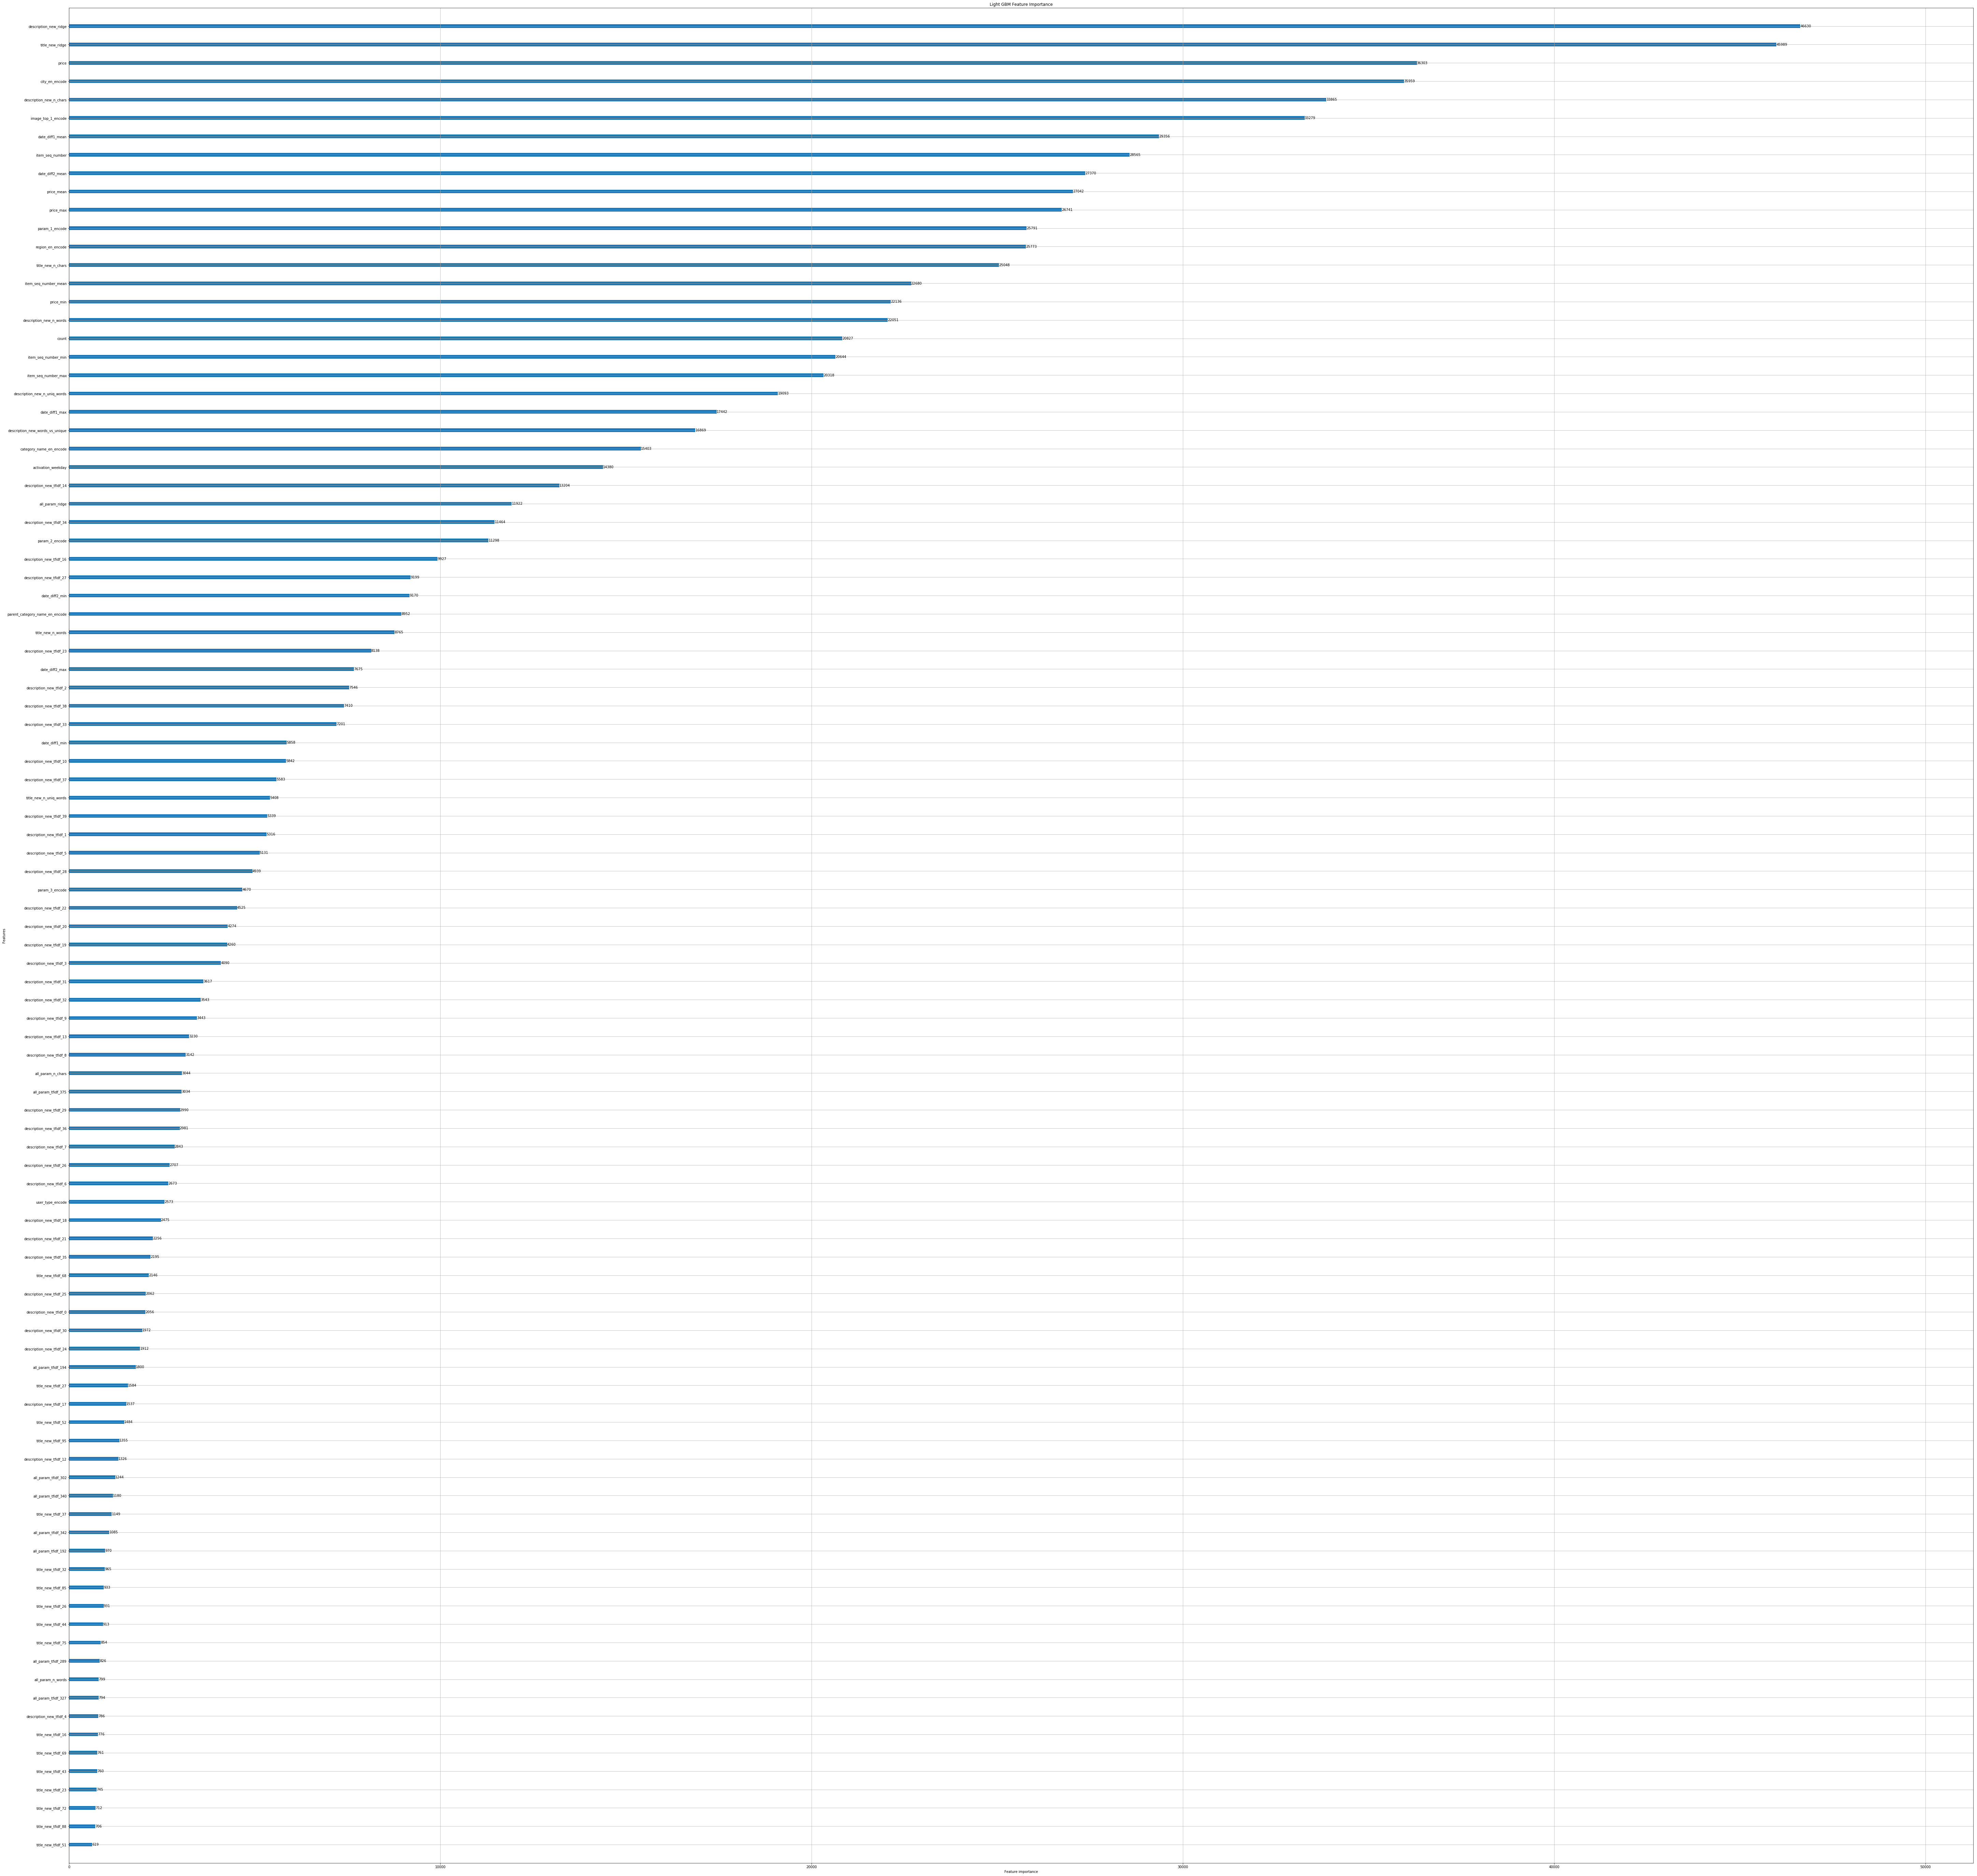

In [72]:
f, ax = plt.subplots(figsize=[100,100])
lgb.plot_importance(gbm, max_num_features=100, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

In [73]:
from IPython.display import Image
Image(filename='feature_import.png') 

### XGBoost Training

In [74]:
## Set datasets for training, validation and test
xgb_train = xgb.DMatrix(X_train, label = y_train)
xgb_val = xgb.DMatrix(X_valid, label = y_valid)
xgb_test=xgb.DMatrix(X_test)

In [75]:
## Set parameters
params = {'booster':'gbtree', 'objective': 'reg:linear', 'gamma':0.1, 'max_depth':12, 'lambda':2, 'subsample':0.7, 
          'colsample_bytree':0.7, 'min_child_weight':3, 'silent':0 , 'eta': 0.007, 'seed':12345, 'eval_metric': 'rmse'}

In [76]:
%%time
## Training model
plst = list(params.items())
num_rounds = 10000
watchlist = [(xgb_train, 'train'),(xgb_val, 'val')]
model = xgb.train(plst, xgb_train, num_rounds, watchlist,early_stopping_rounds=100)
model.save_model('xgb.model')
print("best best_ntree_limit",model.best_ntree_limit)
preds = model.predict(xgb_test,ntree_limit=model.best_ntree_limit)

[0]	train-rmse:0.442534	val-rmse:0.442611
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[1]	train-rmse:0.440239	val-rmse:0.440336
[2]	train-rmse:0.437989	val-rmse:0.438106
[3]	train-rmse:0.435787	val-rmse:0.435918
[4]	train-rmse:0.433559	val-rmse:0.43371
[5]	train-rmse:0.431342	val-rmse:0.431517
[6]	train-rmse:0.429166	val-rmse:0.429357
[7]	train-rmse:0.426984	val-rmse:0.427196
[8]	train-rmse:0.424823	val-rmse:0.425059
[9]	train-rmse:0.42268	val-rmse:0.42294
[10]	train-rmse:0.420565	val-rmse:0.420846
[11]	train-rmse:0.41847	val-rmse:0.418773
[12]	train-rmse:0.416391	val-rmse:0.416712
[13]	train-rmse:0.414333	val-rmse:0.414677
[14]	train-rmse:0.412282	val-rmse:0.412648
[15]	train-rmse:0.41025	val-rmse:0.41064
[16]	train-rmse:0.408234	val-rmse:0.408647
[17]	train-rmse:0.406245	val-rmse:0.406681
[18]	train-rmse:0.404307	val-rmse:0.404761
[19]	train-rmse:0.402345	val-rmse:0.402822
[20]	train-rms

[187]	train-rmse:0.242273	val-rmse:0.24781
[188]	train-rmse:0.241936	val-rmse:0.247507
[189]	train-rmse:0.241601	val-rmse:0.247207
[190]	train-rmse:0.241263	val-rmse:0.246907
[191]	train-rmse:0.240939	val-rmse:0.246614
[192]	train-rmse:0.240606	val-rmse:0.246318
[193]	train-rmse:0.240293	val-rmse:0.246032
[194]	train-rmse:0.239981	val-rmse:0.24575
[195]	train-rmse:0.239669	val-rmse:0.24547
[196]	train-rmse:0.239353	val-rmse:0.245191
[197]	train-rmse:0.239052	val-rmse:0.24492
[198]	train-rmse:0.238743	val-rmse:0.244646
[199]	train-rmse:0.238443	val-rmse:0.244375
[200]	train-rmse:0.238145	val-rmse:0.244109
[201]	train-rmse:0.237851	val-rmse:0.243846
[202]	train-rmse:0.23757	val-rmse:0.243594
[203]	train-rmse:0.237278	val-rmse:0.243336
[204]	train-rmse:0.236994	val-rmse:0.243082
[205]	train-rmse:0.236718	val-rmse:0.242831
[206]	train-rmse:0.236444	val-rmse:0.242589
[207]	train-rmse:0.236171	val-rmse:0.242346
[208]	train-rmse:0.235896	val-rmse:0.242106
[209]	train-rmse:0.235636	val-rmse:0.

[374]	train-rmse:0.214772	val-rmse:0.225437
[375]	train-rmse:0.214719	val-rmse:0.225406
[376]	train-rmse:0.21466	val-rmse:0.225374
[377]	train-rmse:0.214603	val-rmse:0.225341
[378]	train-rmse:0.214548	val-rmse:0.22531
[379]	train-rmse:0.214499	val-rmse:0.225281
[380]	train-rmse:0.214447	val-rmse:0.225251
[381]	train-rmse:0.214391	val-rmse:0.22522
[382]	train-rmse:0.214341	val-rmse:0.225191
[383]	train-rmse:0.214288	val-rmse:0.225162
[384]	train-rmse:0.214245	val-rmse:0.225137
[385]	train-rmse:0.214194	val-rmse:0.225109
[386]	train-rmse:0.214147	val-rmse:0.225083
[387]	train-rmse:0.214106	val-rmse:0.225058
[388]	train-rmse:0.214052	val-rmse:0.22503
[389]	train-rmse:0.214008	val-rmse:0.225005
[390]	train-rmse:0.213958	val-rmse:0.224976
[391]	train-rmse:0.213905	val-rmse:0.224946
[392]	train-rmse:0.213858	val-rmse:0.224919
[393]	train-rmse:0.213809	val-rmse:0.224894
[394]	train-rmse:0.213763	val-rmse:0.224867
[395]	train-rmse:0.213721	val-rmse:0.224845
[396]	train-rmse:0.213671	val-rmse:0

[562]	train-rmse:0.208653	val-rmse:0.222815
[563]	train-rmse:0.208632	val-rmse:0.22281
[564]	train-rmse:0.208609	val-rmse:0.222805
[565]	train-rmse:0.208588	val-rmse:0.2228
[566]	train-rmse:0.208563	val-rmse:0.222792
[567]	train-rmse:0.20854	val-rmse:0.222787
[568]	train-rmse:0.208527	val-rmse:0.222783
[569]	train-rmse:0.208509	val-rmse:0.222777
[570]	train-rmse:0.20849	val-rmse:0.222772
[571]	train-rmse:0.208475	val-rmse:0.222768
[572]	train-rmse:0.208453	val-rmse:0.222763
[573]	train-rmse:0.208429	val-rmse:0.222757
[574]	train-rmse:0.208407	val-rmse:0.222751
[575]	train-rmse:0.208388	val-rmse:0.222748
[576]	train-rmse:0.208365	val-rmse:0.222741
[577]	train-rmse:0.208347	val-rmse:0.222736
[578]	train-rmse:0.208331	val-rmse:0.222733
[579]	train-rmse:0.208305	val-rmse:0.222726
[580]	train-rmse:0.208286	val-rmse:0.222721
[581]	train-rmse:0.208266	val-rmse:0.222716
[582]	train-rmse:0.208246	val-rmse:0.222711
[583]	train-rmse:0.208223	val-rmse:0.222706
[584]	train-rmse:0.208199	val-rmse:0.

[750]	train-rmse:0.20543	val-rmse:0.222119
[751]	train-rmse:0.205415	val-rmse:0.222115
[752]	train-rmse:0.205398	val-rmse:0.222112
[753]	train-rmse:0.205388	val-rmse:0.22211
[754]	train-rmse:0.205374	val-rmse:0.222108
[755]	train-rmse:0.205363	val-rmse:0.222106
[756]	train-rmse:0.205351	val-rmse:0.222104
[757]	train-rmse:0.205341	val-rmse:0.222102
[758]	train-rmse:0.205329	val-rmse:0.222101
[759]	train-rmse:0.20531	val-rmse:0.222099
[760]	train-rmse:0.205294	val-rmse:0.222096
[761]	train-rmse:0.205282	val-rmse:0.222093
[762]	train-rmse:0.205267	val-rmse:0.222092
[763]	train-rmse:0.205255	val-rmse:0.22209
[764]	train-rmse:0.20524	val-rmse:0.222088
[765]	train-rmse:0.205228	val-rmse:0.222086
[766]	train-rmse:0.205216	val-rmse:0.222084
[767]	train-rmse:0.205202	val-rmse:0.222082
[768]	train-rmse:0.205191	val-rmse:0.22208
[769]	train-rmse:0.205179	val-rmse:0.222078
[770]	train-rmse:0.205162	val-rmse:0.222075
[771]	train-rmse:0.205149	val-rmse:0.222074
[772]	train-rmse:0.205131	val-rmse:0.2

[938]	train-rmse:0.203073	val-rmse:0.221718
[939]	train-rmse:0.203064	val-rmse:0.221717
[940]	train-rmse:0.203053	val-rmse:0.221715
[941]	train-rmse:0.203046	val-rmse:0.221714
[942]	train-rmse:0.203039	val-rmse:0.221713
[943]	train-rmse:0.203025	val-rmse:0.22171
[944]	train-rmse:0.203019	val-rmse:0.221709
[945]	train-rmse:0.203007	val-rmse:0.221708
[946]	train-rmse:0.202988	val-rmse:0.221705
[947]	train-rmse:0.202976	val-rmse:0.221704
[948]	train-rmse:0.202969	val-rmse:0.221703
[949]	train-rmse:0.202956	val-rmse:0.221702
[950]	train-rmse:0.202943	val-rmse:0.2217
[951]	train-rmse:0.202929	val-rmse:0.221698
[952]	train-rmse:0.202922	val-rmse:0.221697
[953]	train-rmse:0.202911	val-rmse:0.221696
[954]	train-rmse:0.202905	val-rmse:0.221695
[955]	train-rmse:0.202892	val-rmse:0.221693
[956]	train-rmse:0.202884	val-rmse:0.221693
[957]	train-rmse:0.202876	val-rmse:0.221692
[958]	train-rmse:0.202867	val-rmse:0.221689
[959]	train-rmse:0.20285	val-rmse:0.221685
[960]	train-rmse:0.202843	val-rmse:0

[1123]	train-rmse:0.201204	val-rmse:0.221453
[1124]	train-rmse:0.201194	val-rmse:0.221452
[1125]	train-rmse:0.201176	val-rmse:0.22145
[1126]	train-rmse:0.201162	val-rmse:0.221446
[1127]	train-rmse:0.201153	val-rmse:0.221446
[1128]	train-rmse:0.201145	val-rmse:0.221445
[1129]	train-rmse:0.201136	val-rmse:0.221443
[1130]	train-rmse:0.201123	val-rmse:0.221441
[1131]	train-rmse:0.201113	val-rmse:0.22144
[1132]	train-rmse:0.201106	val-rmse:0.221439
[1133]	train-rmse:0.201099	val-rmse:0.221439
[1134]	train-rmse:0.201093	val-rmse:0.221438
[1135]	train-rmse:0.201082	val-rmse:0.221436
[1136]	train-rmse:0.201075	val-rmse:0.221436
[1137]	train-rmse:0.201067	val-rmse:0.221435
[1138]	train-rmse:0.201058	val-rmse:0.221433
[1139]	train-rmse:0.201051	val-rmse:0.221431
[1140]	train-rmse:0.201045	val-rmse:0.22143
[1141]	train-rmse:0.201038	val-rmse:0.221429
[1142]	train-rmse:0.201027	val-rmse:0.221428
[1143]	train-rmse:0.201018	val-rmse:0.221427
[1144]	train-rmse:0.201011	val-rmse:0.221426
[1145]	train-

[1306]	train-rmse:0.199636	val-rmse:0.221245
[1307]	train-rmse:0.199627	val-rmse:0.221244
[1308]	train-rmse:0.199617	val-rmse:0.221243
[1309]	train-rmse:0.199612	val-rmse:0.221242
[1310]	train-rmse:0.199605	val-rmse:0.221241
[1311]	train-rmse:0.199596	val-rmse:0.221241
[1312]	train-rmse:0.199583	val-rmse:0.221239
[1313]	train-rmse:0.199578	val-rmse:0.221239
[1314]	train-rmse:0.199569	val-rmse:0.221237
[1315]	train-rmse:0.199563	val-rmse:0.221236
[1316]	train-rmse:0.199559	val-rmse:0.221235
[1317]	train-rmse:0.199551	val-rmse:0.221233
[1318]	train-rmse:0.199541	val-rmse:0.221233
[1319]	train-rmse:0.199536	val-rmse:0.221232
[1320]	train-rmse:0.19953	val-rmse:0.221232
[1321]	train-rmse:0.199522	val-rmse:0.221231
[1322]	train-rmse:0.199513	val-rmse:0.22123
[1323]	train-rmse:0.199503	val-rmse:0.221229
[1324]	train-rmse:0.199497	val-rmse:0.221227
[1325]	train-rmse:0.199489	val-rmse:0.221226
[1326]	train-rmse:0.199484	val-rmse:0.221226
[1327]	train-rmse:0.199481	val-rmse:0.221226
[1328]	train

[1490]	train-rmse:0.198296	val-rmse:0.221096
[1491]	train-rmse:0.198292	val-rmse:0.221096
[1492]	train-rmse:0.198288	val-rmse:0.221095
[1493]	train-rmse:0.19828	val-rmse:0.221093
[1494]	train-rmse:0.198277	val-rmse:0.221092
[1495]	train-rmse:0.198264	val-rmse:0.221091
[1496]	train-rmse:0.198261	val-rmse:0.221091
[1497]	train-rmse:0.198255	val-rmse:0.22109
[1498]	train-rmse:0.198253	val-rmse:0.22109
[1499]	train-rmse:0.19825	val-rmse:0.22109
[1500]	train-rmse:0.198241	val-rmse:0.221089
[1501]	train-rmse:0.198229	val-rmse:0.221087
[1502]	train-rmse:0.198224	val-rmse:0.221086
[1503]	train-rmse:0.198211	val-rmse:0.221084
[1504]	train-rmse:0.198204	val-rmse:0.221084
[1505]	train-rmse:0.1982	val-rmse:0.221084
[1506]	train-rmse:0.198195	val-rmse:0.221083
[1507]	train-rmse:0.198186	val-rmse:0.221082
[1508]	train-rmse:0.19818	val-rmse:0.221082
[1509]	train-rmse:0.198177	val-rmse:0.221082
[1510]	train-rmse:0.198172	val-rmse:0.221081
[1511]	train-rmse:0.198167	val-rmse:0.221081
[1512]	train-rmse:

[1673]	train-rmse:0.197166	val-rmse:0.220989
[1674]	train-rmse:0.197157	val-rmse:0.220988
[1675]	train-rmse:0.197155	val-rmse:0.220988
[1676]	train-rmse:0.197146	val-rmse:0.220987
[1677]	train-rmse:0.197138	val-rmse:0.220986
[1678]	train-rmse:0.19713	val-rmse:0.220986
[1679]	train-rmse:0.197125	val-rmse:0.220986
[1680]	train-rmse:0.197123	val-rmse:0.220985
[1681]	train-rmse:0.197118	val-rmse:0.220985
[1682]	train-rmse:0.197113	val-rmse:0.220985
[1683]	train-rmse:0.197108	val-rmse:0.220984
[1684]	train-rmse:0.197104	val-rmse:0.220984
[1685]	train-rmse:0.197098	val-rmse:0.220983
[1686]	train-rmse:0.197091	val-rmse:0.220983
[1687]	train-rmse:0.197079	val-rmse:0.22098
[1688]	train-rmse:0.197073	val-rmse:0.22098
[1689]	train-rmse:0.19707	val-rmse:0.22098
[1690]	train-rmse:0.197066	val-rmse:0.220979
[1691]	train-rmse:0.197059	val-rmse:0.220979
[1692]	train-rmse:0.197054	val-rmse:0.220979
[1693]	train-rmse:0.197051	val-rmse:0.220979
[1694]	train-rmse:0.197045	val-rmse:0.220978
[1695]	train-rm

[1856]	train-rmse:0.196122	val-rmse:0.220893
[1857]	train-rmse:0.196115	val-rmse:0.220892
[1858]	train-rmse:0.196107	val-rmse:0.220891
[1859]	train-rmse:0.196101	val-rmse:0.220891
[1860]	train-rmse:0.196095	val-rmse:0.220891
[1861]	train-rmse:0.196088	val-rmse:0.22089
[1862]	train-rmse:0.196084	val-rmse:0.22089
[1863]	train-rmse:0.196071	val-rmse:0.220888
[1864]	train-rmse:0.196068	val-rmse:0.220887
[1865]	train-rmse:0.19606	val-rmse:0.220886
[1866]	train-rmse:0.196055	val-rmse:0.220886
[1867]	train-rmse:0.19605	val-rmse:0.220885
[1868]	train-rmse:0.196045	val-rmse:0.220885
[1869]	train-rmse:0.196038	val-rmse:0.220883
[1870]	train-rmse:0.196033	val-rmse:0.220883
[1871]	train-rmse:0.196028	val-rmse:0.220883
[1872]	train-rmse:0.196026	val-rmse:0.220882
[1873]	train-rmse:0.196019	val-rmse:0.220881
[1874]	train-rmse:0.196013	val-rmse:0.220881
[1875]	train-rmse:0.196006	val-rmse:0.220879
[1876]	train-rmse:0.195989	val-rmse:0.220877
[1877]	train-rmse:0.195986	val-rmse:0.220876
[1878]	train-r

[2039]	train-rmse:0.195075	val-rmse:0.220793
[2040]	train-rmse:0.195069	val-rmse:0.220793
[2041]	train-rmse:0.195063	val-rmse:0.220792
[2042]	train-rmse:0.195056	val-rmse:0.220792
[2043]	train-rmse:0.195048	val-rmse:0.220791
[2044]	train-rmse:0.195046	val-rmse:0.220791
[2045]	train-rmse:0.195043	val-rmse:0.220791
[2046]	train-rmse:0.19504	val-rmse:0.22079
[2047]	train-rmse:0.195033	val-rmse:0.22079
[2048]	train-rmse:0.195025	val-rmse:0.220789
[2049]	train-rmse:0.195022	val-rmse:0.220789
[2050]	train-rmse:0.195017	val-rmse:0.220788
[2051]	train-rmse:0.195009	val-rmse:0.220787
[2052]	train-rmse:0.195007	val-rmse:0.220786
[2053]	train-rmse:0.195002	val-rmse:0.220786
[2054]	train-rmse:0.194996	val-rmse:0.220785
[2055]	train-rmse:0.194993	val-rmse:0.220785
[2056]	train-rmse:0.194987	val-rmse:0.220785
[2057]	train-rmse:0.19498	val-rmse:0.220784
[2058]	train-rmse:0.194975	val-rmse:0.220784
[2059]	train-rmse:0.194969	val-rmse:0.220784
[2060]	train-rmse:0.194965	val-rmse:0.220784
[2061]	train-r

[2222]	train-rmse:0.194071	val-rmse:0.220712
[2223]	train-rmse:0.194068	val-rmse:0.220712
[2224]	train-rmse:0.194061	val-rmse:0.220711
[2225]	train-rmse:0.194058	val-rmse:0.220711
[2226]	train-rmse:0.194054	val-rmse:0.220711
[2227]	train-rmse:0.194047	val-rmse:0.22071
[2228]	train-rmse:0.194046	val-rmse:0.22071
[2229]	train-rmse:0.194038	val-rmse:0.22071
[2230]	train-rmse:0.19403	val-rmse:0.220709
[2231]	train-rmse:0.194022	val-rmse:0.220709
[2232]	train-rmse:0.194019	val-rmse:0.220708
[2233]	train-rmse:0.194014	val-rmse:0.220708
[2234]	train-rmse:0.194011	val-rmse:0.220708
[2235]	train-rmse:0.194009	val-rmse:0.220707
[2236]	train-rmse:0.194007	val-rmse:0.220707
[2237]	train-rmse:0.194	val-rmse:0.220707
[2238]	train-rmse:0.193994	val-rmse:0.220707
[2239]	train-rmse:0.19399	val-rmse:0.220707
[2240]	train-rmse:0.193985	val-rmse:0.220707
[2241]	train-rmse:0.193983	val-rmse:0.220707
[2242]	train-rmse:0.19398	val-rmse:0.220707
[2243]	train-rmse:0.193978	val-rmse:0.220707
[2244]	train-rmse:0

[2406]	train-rmse:0.193129	val-rmse:0.220635
[2407]	train-rmse:0.193123	val-rmse:0.220634
[2408]	train-rmse:0.19312	val-rmse:0.220634
[2409]	train-rmse:0.193118	val-rmse:0.220634
[2410]	train-rmse:0.193117	val-rmse:0.220634
[2411]	train-rmse:0.19311	val-rmse:0.220633
[2412]	train-rmse:0.193107	val-rmse:0.220633
[2413]	train-rmse:0.193104	val-rmse:0.220633
[2414]	train-rmse:0.1931	val-rmse:0.220634
[2415]	train-rmse:0.193098	val-rmse:0.220634
[2416]	train-rmse:0.193094	val-rmse:0.220633
[2417]	train-rmse:0.193087	val-rmse:0.220633
[2418]	train-rmse:0.193083	val-rmse:0.220632
[2419]	train-rmse:0.193077	val-rmse:0.220632
[2420]	train-rmse:0.193073	val-rmse:0.220632
[2421]	train-rmse:0.193069	val-rmse:0.220632
[2422]	train-rmse:0.193063	val-rmse:0.220631
[2423]	train-rmse:0.193059	val-rmse:0.220631
[2424]	train-rmse:0.193055	val-rmse:0.220631
[2425]	train-rmse:0.193049	val-rmse:0.220631
[2426]	train-rmse:0.193044	val-rmse:0.22063
[2427]	train-rmse:0.19304	val-rmse:0.22063
[2428]	train-rmse

[2589]	train-rmse:0.192218	val-rmse:0.220578
[2590]	train-rmse:0.192209	val-rmse:0.220577
[2591]	train-rmse:0.192205	val-rmse:0.220577
[2592]	train-rmse:0.192203	val-rmse:0.220577
[2593]	train-rmse:0.192198	val-rmse:0.220577
[2594]	train-rmse:0.192188	val-rmse:0.220576
[2595]	train-rmse:0.192182	val-rmse:0.220576
[2596]	train-rmse:0.19218	val-rmse:0.220575
[2597]	train-rmse:0.192172	val-rmse:0.220575
[2598]	train-rmse:0.192171	val-rmse:0.220575
[2599]	train-rmse:0.192164	val-rmse:0.220575
[2600]	train-rmse:0.192161	val-rmse:0.220575
[2601]	train-rmse:0.192155	val-rmse:0.220574
[2602]	train-rmse:0.192152	val-rmse:0.220574
[2603]	train-rmse:0.192145	val-rmse:0.220574
[2604]	train-rmse:0.192141	val-rmse:0.220574
[2605]	train-rmse:0.192129	val-rmse:0.220572
[2606]	train-rmse:0.192125	val-rmse:0.220572
[2607]	train-rmse:0.192121	val-rmse:0.220572
[2608]	train-rmse:0.192114	val-rmse:0.220572
[2609]	train-rmse:0.192113	val-rmse:0.220572
[2610]	train-rmse:0.19211	val-rmse:0.220572
[2611]	train

[2772]	train-rmse:0.191343	val-rmse:0.220523
[2773]	train-rmse:0.19134	val-rmse:0.220523
[2774]	train-rmse:0.191339	val-rmse:0.220523
[2775]	train-rmse:0.191336	val-rmse:0.220523
[2776]	train-rmse:0.191329	val-rmse:0.220523
[2777]	train-rmse:0.191325	val-rmse:0.220522
[2778]	train-rmse:0.191314	val-rmse:0.220521
[2779]	train-rmse:0.191312	val-rmse:0.220521
[2780]	train-rmse:0.191308	val-rmse:0.22052
[2781]	train-rmse:0.191295	val-rmse:0.22052
[2782]	train-rmse:0.191289	val-rmse:0.22052
[2783]	train-rmse:0.191284	val-rmse:0.22052
[2784]	train-rmse:0.191282	val-rmse:0.22052
[2785]	train-rmse:0.191278	val-rmse:0.22052
[2786]	train-rmse:0.191276	val-rmse:0.22052
[2787]	train-rmse:0.191275	val-rmse:0.22052
[2788]	train-rmse:0.191273	val-rmse:0.22052
[2789]	train-rmse:0.191269	val-rmse:0.220519
[2790]	train-rmse:0.191265	val-rmse:0.220519
[2791]	train-rmse:0.191261	val-rmse:0.220518
[2792]	train-rmse:0.191258	val-rmse:0.220518
[2793]	train-rmse:0.19125	val-rmse:0.220518
[2794]	train-rmse:0.1

[2956]	train-rmse:0.190481	val-rmse:0.22047
[2957]	train-rmse:0.190476	val-rmse:0.22047
[2958]	train-rmse:0.190469	val-rmse:0.220469
[2959]	train-rmse:0.190466	val-rmse:0.220469
[2960]	train-rmse:0.190463	val-rmse:0.220469
[2961]	train-rmse:0.190458	val-rmse:0.220469
[2962]	train-rmse:0.190448	val-rmse:0.220468
[2963]	train-rmse:0.190444	val-rmse:0.220468
[2964]	train-rmse:0.190435	val-rmse:0.220466
[2965]	train-rmse:0.190428	val-rmse:0.220465
[2966]	train-rmse:0.190425	val-rmse:0.220465
[2967]	train-rmse:0.190419	val-rmse:0.220465
[2968]	train-rmse:0.190415	val-rmse:0.220465
[2969]	train-rmse:0.19041	val-rmse:0.220465
[2970]	train-rmse:0.190408	val-rmse:0.220465
[2971]	train-rmse:0.190403	val-rmse:0.220464
[2972]	train-rmse:0.190396	val-rmse:0.220463
[2973]	train-rmse:0.190391	val-rmse:0.220463
[2974]	train-rmse:0.190385	val-rmse:0.220463
[2975]	train-rmse:0.190381	val-rmse:0.220463
[2976]	train-rmse:0.19038	val-rmse:0.220463
[2977]	train-rmse:0.190374	val-rmse:0.220462
[2978]	train-r

[3139]	train-rmse:0.189662	val-rmse:0.220415
[3140]	train-rmse:0.189658	val-rmse:0.220415
[3141]	train-rmse:0.189653	val-rmse:0.220415
[3142]	train-rmse:0.189642	val-rmse:0.220413
[3143]	train-rmse:0.189635	val-rmse:0.220413
[3144]	train-rmse:0.18963	val-rmse:0.220413
[3145]	train-rmse:0.189627	val-rmse:0.220413
[3146]	train-rmse:0.189624	val-rmse:0.220413
[3147]	train-rmse:0.189615	val-rmse:0.220412
[3148]	train-rmse:0.189612	val-rmse:0.220412
[3149]	train-rmse:0.189608	val-rmse:0.220411
[3150]	train-rmse:0.189606	val-rmse:0.220411
[3151]	train-rmse:0.189603	val-rmse:0.220411
[3152]	train-rmse:0.1896	val-rmse:0.220411
[3153]	train-rmse:0.189598	val-rmse:0.220411
[3154]	train-rmse:0.189592	val-rmse:0.220412
[3155]	train-rmse:0.189587	val-rmse:0.220411
[3156]	train-rmse:0.189584	val-rmse:0.220411
[3157]	train-rmse:0.189581	val-rmse:0.220411
[3158]	train-rmse:0.189576	val-rmse:0.220411
[3159]	train-rmse:0.189571	val-rmse:0.220411
[3160]	train-rmse:0.189565	val-rmse:0.22041
[3161]	train-r

[3322]	train-rmse:0.188872	val-rmse:0.22037
[3323]	train-rmse:0.188869	val-rmse:0.22037
[3324]	train-rmse:0.188864	val-rmse:0.220369
[3325]	train-rmse:0.18886	val-rmse:0.220369
[3326]	train-rmse:0.188855	val-rmse:0.220369
[3327]	train-rmse:0.188851	val-rmse:0.220369
[3328]	train-rmse:0.188848	val-rmse:0.220368
[3329]	train-rmse:0.188846	val-rmse:0.220368
[3330]	train-rmse:0.188842	val-rmse:0.220368
[3331]	train-rmse:0.188837	val-rmse:0.220368
[3332]	train-rmse:0.188834	val-rmse:0.220368
[3333]	train-rmse:0.188828	val-rmse:0.220368
[3334]	train-rmse:0.188823	val-rmse:0.220368
[3335]	train-rmse:0.188819	val-rmse:0.220368
[3336]	train-rmse:0.188812	val-rmse:0.220367
[3337]	train-rmse:0.188806	val-rmse:0.220367
[3338]	train-rmse:0.188802	val-rmse:0.220366
[3339]	train-rmse:0.188799	val-rmse:0.220366
[3340]	train-rmse:0.188786	val-rmse:0.220365
[3341]	train-rmse:0.188783	val-rmse:0.220365
[3342]	train-rmse:0.18878	val-rmse:0.220364
[3343]	train-rmse:0.188773	val-rmse:0.220364
[3344]	train-r

[3505]	train-rmse:0.188071	val-rmse:0.220329
[3506]	train-rmse:0.188066	val-rmse:0.220329
[3507]	train-rmse:0.188063	val-rmse:0.220328
[3508]	train-rmse:0.188054	val-rmse:0.220328
[3509]	train-rmse:0.188051	val-rmse:0.220328
[3510]	train-rmse:0.188047	val-rmse:0.220328
[3511]	train-rmse:0.188045	val-rmse:0.220328
[3512]	train-rmse:0.188042	val-rmse:0.220328
[3513]	train-rmse:0.188038	val-rmse:0.220328
[3514]	train-rmse:0.188036	val-rmse:0.220327
[3515]	train-rmse:0.188032	val-rmse:0.220327
[3516]	train-rmse:0.188031	val-rmse:0.220327
[3517]	train-rmse:0.188028	val-rmse:0.220327
[3518]	train-rmse:0.188025	val-rmse:0.220327
[3519]	train-rmse:0.18802	val-rmse:0.220327
[3520]	train-rmse:0.188018	val-rmse:0.220327
[3521]	train-rmse:0.188015	val-rmse:0.220326
[3522]	train-rmse:0.188012	val-rmse:0.220326
[3523]	train-rmse:0.18801	val-rmse:0.220326
[3524]	train-rmse:0.188006	val-rmse:0.220326
[3525]	train-rmse:0.188002	val-rmse:0.220326
[3526]	train-rmse:0.188	val-rmse:0.220326
[3527]	train-rm

[3688]	train-rmse:0.187265	val-rmse:0.22029
[3689]	train-rmse:0.187256	val-rmse:0.22029
[3690]	train-rmse:0.187253	val-rmse:0.220289
[3691]	train-rmse:0.187248	val-rmse:0.220289
[3692]	train-rmse:0.18724	val-rmse:0.220289
[3693]	train-rmse:0.187232	val-rmse:0.220288
[3694]	train-rmse:0.187229	val-rmse:0.220288
[3695]	train-rmse:0.187224	val-rmse:0.220288
[3696]	train-rmse:0.187222	val-rmse:0.220288
[3697]	train-rmse:0.187212	val-rmse:0.220287
[3698]	train-rmse:0.187207	val-rmse:0.220287
[3699]	train-rmse:0.1872	val-rmse:0.220286
[3700]	train-rmse:0.187198	val-rmse:0.220286
[3701]	train-rmse:0.187194	val-rmse:0.220286
[3702]	train-rmse:0.187188	val-rmse:0.220286
[3703]	train-rmse:0.187177	val-rmse:0.220284
[3704]	train-rmse:0.187174	val-rmse:0.220284
[3705]	train-rmse:0.187168	val-rmse:0.220284
[3706]	train-rmse:0.187159	val-rmse:0.220284
[3707]	train-rmse:0.187153	val-rmse:0.220283
[3708]	train-rmse:0.18715	val-rmse:0.220283
[3709]	train-rmse:0.187145	val-rmse:0.220283
[3710]	train-rms

[3871]	train-rmse:0.18643	val-rmse:0.220243
[3872]	train-rmse:0.186426	val-rmse:0.220243
[3873]	train-rmse:0.186423	val-rmse:0.220243
[3874]	train-rmse:0.18642	val-rmse:0.220243
[3875]	train-rmse:0.186419	val-rmse:0.220243
[3876]	train-rmse:0.186415	val-rmse:0.220243
[3877]	train-rmse:0.18641	val-rmse:0.220242
[3878]	train-rmse:0.186407	val-rmse:0.220242
[3879]	train-rmse:0.186402	val-rmse:0.220242
[3880]	train-rmse:0.1864	val-rmse:0.220242
[3881]	train-rmse:0.186391	val-rmse:0.220242
[3882]	train-rmse:0.186386	val-rmse:0.220242
[3883]	train-rmse:0.186382	val-rmse:0.220241
[3884]	train-rmse:0.186372	val-rmse:0.220241
[3885]	train-rmse:0.186369	val-rmse:0.22024
[3886]	train-rmse:0.186364	val-rmse:0.22024
[3887]	train-rmse:0.186359	val-rmse:0.22024
[3888]	train-rmse:0.186355	val-rmse:0.22024
[3889]	train-rmse:0.186353	val-rmse:0.22024
[3890]	train-rmse:0.18635	val-rmse:0.22024
[3891]	train-rmse:0.186344	val-rmse:0.220239
[3892]	train-rmse:0.18634	val-rmse:0.220239
[3893]	train-rmse:0.186

[4055]	train-rmse:0.185622	val-rmse:0.220202
[4056]	train-rmse:0.185619	val-rmse:0.220202
[4057]	train-rmse:0.185616	val-rmse:0.220202
[4058]	train-rmse:0.185611	val-rmse:0.220202
[4059]	train-rmse:0.185606	val-rmse:0.220201
[4060]	train-rmse:0.185603	val-rmse:0.220201
[4061]	train-rmse:0.185601	val-rmse:0.220201
[4062]	train-rmse:0.185597	val-rmse:0.220201
[4063]	train-rmse:0.185593	val-rmse:0.220201
[4064]	train-rmse:0.185589	val-rmse:0.220201
[4065]	train-rmse:0.185586	val-rmse:0.220201
[4066]	train-rmse:0.18558	val-rmse:0.2202
[4067]	train-rmse:0.185578	val-rmse:0.2202
[4068]	train-rmse:0.185574	val-rmse:0.2202
[4069]	train-rmse:0.185569	val-rmse:0.2202
[4070]	train-rmse:0.185567	val-rmse:0.2202
[4071]	train-rmse:0.185562	val-rmse:0.220199
[4072]	train-rmse:0.185556	val-rmse:0.220198
[4073]	train-rmse:0.185547	val-rmse:0.220198
[4074]	train-rmse:0.185542	val-rmse:0.220198
[4075]	train-rmse:0.185538	val-rmse:0.220198
[4076]	train-rmse:0.185535	val-rmse:0.220198
[4077]	train-rmse:0.1

[4238]	train-rmse:0.184876	val-rmse:0.220175
[4239]	train-rmse:0.18487	val-rmse:0.220175
[4240]	train-rmse:0.184864	val-rmse:0.220175
[4241]	train-rmse:0.184862	val-rmse:0.220175
[4242]	train-rmse:0.18486	val-rmse:0.220174
[4243]	train-rmse:0.184856	val-rmse:0.220174
[4244]	train-rmse:0.184854	val-rmse:0.220175
[4245]	train-rmse:0.184852	val-rmse:0.220174
[4246]	train-rmse:0.184841	val-rmse:0.220173
[4247]	train-rmse:0.184835	val-rmse:0.220173
[4248]	train-rmse:0.184834	val-rmse:0.220173
[4249]	train-rmse:0.184832	val-rmse:0.220173
[4250]	train-rmse:0.184828	val-rmse:0.220173
[4251]	train-rmse:0.184823	val-rmse:0.220172
[4252]	train-rmse:0.184818	val-rmse:0.220172
[4253]	train-rmse:0.184815	val-rmse:0.220172
[4254]	train-rmse:0.184812	val-rmse:0.220172
[4255]	train-rmse:0.184806	val-rmse:0.220172
[4256]	train-rmse:0.184795	val-rmse:0.220172
[4257]	train-rmse:0.184792	val-rmse:0.220172
[4258]	train-rmse:0.184789	val-rmse:0.220172
[4259]	train-rmse:0.184783	val-rmse:0.220171
[4260]	train

[4421]	train-rmse:0.184121	val-rmse:0.220143
[4422]	train-rmse:0.184116	val-rmse:0.220143
[4423]	train-rmse:0.184114	val-rmse:0.220143
[4424]	train-rmse:0.184109	val-rmse:0.220143
[4425]	train-rmse:0.184106	val-rmse:0.220142
[4426]	train-rmse:0.184105	val-rmse:0.220143
[4427]	train-rmse:0.184101	val-rmse:0.220143
[4428]	train-rmse:0.184097	val-rmse:0.220143
[4429]	train-rmse:0.184095	val-rmse:0.220143
[4430]	train-rmse:0.184094	val-rmse:0.220143
[4431]	train-rmse:0.184092	val-rmse:0.220143
[4432]	train-rmse:0.184088	val-rmse:0.220143
[4433]	train-rmse:0.184085	val-rmse:0.220142
[4434]	train-rmse:0.184081	val-rmse:0.220143
[4435]	train-rmse:0.184078	val-rmse:0.220142
[4436]	train-rmse:0.184075	val-rmse:0.220142
[4437]	train-rmse:0.184072	val-rmse:0.220142
[4438]	train-rmse:0.184069	val-rmse:0.220142
[4439]	train-rmse:0.184062	val-rmse:0.220141
[4440]	train-rmse:0.184054	val-rmse:0.220141
[4441]	train-rmse:0.184052	val-rmse:0.220141
[4442]	train-rmse:0.184049	val-rmse:0.220141
[4443]	tra

[4604]	train-rmse:0.183395	val-rmse:0.22012
[4605]	train-rmse:0.183389	val-rmse:0.22012
[4606]	train-rmse:0.183383	val-rmse:0.220119
[4607]	train-rmse:0.183376	val-rmse:0.220119
[4608]	train-rmse:0.183373	val-rmse:0.220119
[4609]	train-rmse:0.18337	val-rmse:0.220119
[4610]	train-rmse:0.183367	val-rmse:0.220119
[4611]	train-rmse:0.183363	val-rmse:0.220119
[4612]	train-rmse:0.18336	val-rmse:0.220119
[4613]	train-rmse:0.183357	val-rmse:0.220118
[4614]	train-rmse:0.183354	val-rmse:0.220118
[4615]	train-rmse:0.183352	val-rmse:0.220118
[4616]	train-rmse:0.183347	val-rmse:0.220118
[4617]	train-rmse:0.183342	val-rmse:0.220117
[4618]	train-rmse:0.18334	val-rmse:0.220117
[4619]	train-rmse:0.183338	val-rmse:0.220117
[4620]	train-rmse:0.183337	val-rmse:0.220117
[4621]	train-rmse:0.183336	val-rmse:0.220117
[4622]	train-rmse:0.183332	val-rmse:0.220117
[4623]	train-rmse:0.183324	val-rmse:0.220117
[4624]	train-rmse:0.18332	val-rmse:0.220116
[4625]	train-rmse:0.183318	val-rmse:0.220116
[4626]	train-rms

[4787]	train-rmse:0.182642	val-rmse:0.220091
[4788]	train-rmse:0.182638	val-rmse:0.220091
[4789]	train-rmse:0.182636	val-rmse:0.220091
[4790]	train-rmse:0.18263	val-rmse:0.220091
[4791]	train-rmse:0.182627	val-rmse:0.220091
[4792]	train-rmse:0.182623	val-rmse:0.220091
[4793]	train-rmse:0.182616	val-rmse:0.220091
[4794]	train-rmse:0.182613	val-rmse:0.220091
[4795]	train-rmse:0.182611	val-rmse:0.220091
[4796]	train-rmse:0.182607	val-rmse:0.220091
[4797]	train-rmse:0.182603	val-rmse:0.220091
[4798]	train-rmse:0.182598	val-rmse:0.220091
[4799]	train-rmse:0.182594	val-rmse:0.220091
[4800]	train-rmse:0.182591	val-rmse:0.220091
[4801]	train-rmse:0.182586	val-rmse:0.220091
[4802]	train-rmse:0.182584	val-rmse:0.220091
[4803]	train-rmse:0.182582	val-rmse:0.220091
[4804]	train-rmse:0.182578	val-rmse:0.220091
[4805]	train-rmse:0.182575	val-rmse:0.220091
[4806]	train-rmse:0.182568	val-rmse:0.22009
[4807]	train-rmse:0.182562	val-rmse:0.22009
[4808]	train-rmse:0.182558	val-rmse:0.22009
[4809]	train-r

[4970]	train-rmse:0.181914	val-rmse:0.220064
[4971]	train-rmse:0.181907	val-rmse:0.220064
[4972]	train-rmse:0.181903	val-rmse:0.220064
[4973]	train-rmse:0.1819	val-rmse:0.220063
[4974]	train-rmse:0.181894	val-rmse:0.220063
[4975]	train-rmse:0.181891	val-rmse:0.220063
[4976]	train-rmse:0.181887	val-rmse:0.220063
[4977]	train-rmse:0.181883	val-rmse:0.220063
[4978]	train-rmse:0.181877	val-rmse:0.220063
[4979]	train-rmse:0.181872	val-rmse:0.220063
[4980]	train-rmse:0.181862	val-rmse:0.220062
[4981]	train-rmse:0.18186	val-rmse:0.220062
[4982]	train-rmse:0.181853	val-rmse:0.220062
[4983]	train-rmse:0.18185	val-rmse:0.220061
[4984]	train-rmse:0.181846	val-rmse:0.220061
[4985]	train-rmse:0.181845	val-rmse:0.220061
[4986]	train-rmse:0.18184	val-rmse:0.220061
[4987]	train-rmse:0.181833	val-rmse:0.22006
[4988]	train-rmse:0.181828	val-rmse:0.22006
[4989]	train-rmse:0.181822	val-rmse:0.220059
[4990]	train-rmse:0.181817	val-rmse:0.220059
[4991]	train-rmse:0.181815	val-rmse:0.220059
[4992]	train-rmse

[5154]	train-rmse:0.181217	val-rmse:0.220045
[5155]	train-rmse:0.181212	val-rmse:0.220045
[5156]	train-rmse:0.181208	val-rmse:0.220045
[5157]	train-rmse:0.181203	val-rmse:0.220045
[5158]	train-rmse:0.1812	val-rmse:0.220045
[5159]	train-rmse:0.181195	val-rmse:0.220045
[5160]	train-rmse:0.181193	val-rmse:0.220045
[5161]	train-rmse:0.181189	val-rmse:0.220045
[5162]	train-rmse:0.181182	val-rmse:0.220044
[5163]	train-rmse:0.181177	val-rmse:0.220044
[5164]	train-rmse:0.181174	val-rmse:0.220044
[5165]	train-rmse:0.181173	val-rmse:0.220044
[5166]	train-rmse:0.181166	val-rmse:0.220044
[5167]	train-rmse:0.181163	val-rmse:0.220044
[5168]	train-rmse:0.18116	val-rmse:0.220044
[5169]	train-rmse:0.181158	val-rmse:0.220044
[5170]	train-rmse:0.181151	val-rmse:0.220044
[5171]	train-rmse:0.181148	val-rmse:0.220044
[5172]	train-rmse:0.181146	val-rmse:0.220044
[5173]	train-rmse:0.181144	val-rmse:0.220044
[5174]	train-rmse:0.181143	val-rmse:0.220044
[5175]	train-rmse:0.181139	val-rmse:0.220044
[5176]	train-

[5337]	train-rmse:0.180556	val-rmse:0.220031
[5338]	train-rmse:0.180555	val-rmse:0.220031
[5339]	train-rmse:0.180551	val-rmse:0.220031
[5340]	train-rmse:0.180549	val-rmse:0.220032
[5341]	train-rmse:0.180547	val-rmse:0.220032
[5342]	train-rmse:0.180544	val-rmse:0.220032
[5343]	train-rmse:0.180544	val-rmse:0.220032
[5344]	train-rmse:0.180539	val-rmse:0.220031
[5345]	train-rmse:0.180536	val-rmse:0.220031
[5346]	train-rmse:0.180533	val-rmse:0.220031
[5347]	train-rmse:0.180529	val-rmse:0.220031
[5348]	train-rmse:0.180526	val-rmse:0.220031
[5349]	train-rmse:0.18052	val-rmse:0.220031
[5350]	train-rmse:0.180515	val-rmse:0.220031
[5351]	train-rmse:0.180513	val-rmse:0.220031
[5352]	train-rmse:0.180511	val-rmse:0.220031
[5353]	train-rmse:0.180509	val-rmse:0.220031
[5354]	train-rmse:0.180505	val-rmse:0.220031
[5355]	train-rmse:0.180503	val-rmse:0.22003
[5356]	train-rmse:0.180498	val-rmse:0.22003
[5357]	train-rmse:0.180486	val-rmse:0.22003
[5358]	train-rmse:0.180485	val-rmse:0.220029
[5359]	train-r

[5521]	train-rmse:0.179893	val-rmse:0.220011
[5522]	train-rmse:0.17989	val-rmse:0.220011
[5523]	train-rmse:0.179884	val-rmse:0.22001
[5524]	train-rmse:0.179879	val-rmse:0.220011
[5525]	train-rmse:0.179877	val-rmse:0.220011
[5526]	train-rmse:0.179873	val-rmse:0.22001
[5527]	train-rmse:0.17987	val-rmse:0.22001
[5528]	train-rmse:0.179868	val-rmse:0.22001
[5529]	train-rmse:0.179864	val-rmse:0.22001
[5530]	train-rmse:0.179859	val-rmse:0.22001
[5531]	train-rmse:0.179853	val-rmse:0.22001
[5532]	train-rmse:0.179849	val-rmse:0.22001
[5533]	train-rmse:0.179846	val-rmse:0.22001
[5534]	train-rmse:0.179843	val-rmse:0.220009
[5535]	train-rmse:0.179838	val-rmse:0.220009
[5536]	train-rmse:0.179835	val-rmse:0.220009
[5537]	train-rmse:0.17983	val-rmse:0.220009
[5538]	train-rmse:0.179827	val-rmse:0.220009
[5539]	train-rmse:0.179823	val-rmse:0.220009
[5540]	train-rmse:0.179817	val-rmse:0.220008
[5541]	train-rmse:0.179815	val-rmse:0.220008
[5542]	train-rmse:0.179811	val-rmse:0.220008
[5543]	train-rmse:0.17

[5705]	train-rmse:0.179194	val-rmse:0.219989
[5706]	train-rmse:0.179189	val-rmse:0.219989
[5707]	train-rmse:0.179184	val-rmse:0.219989
[5708]	train-rmse:0.179181	val-rmse:0.219989
[5709]	train-rmse:0.179178	val-rmse:0.219989
[5710]	train-rmse:0.179175	val-rmse:0.219989
[5711]	train-rmse:0.179172	val-rmse:0.219989
[5712]	train-rmse:0.179166	val-rmse:0.219988
[5713]	train-rmse:0.179162	val-rmse:0.219988
[5714]	train-rmse:0.179156	val-rmse:0.219988
[5715]	train-rmse:0.179153	val-rmse:0.219988
[5716]	train-rmse:0.179149	val-rmse:0.219988
[5717]	train-rmse:0.179144	val-rmse:0.219988
[5718]	train-rmse:0.179138	val-rmse:0.219987
[5719]	train-rmse:0.179135	val-rmse:0.219987
[5720]	train-rmse:0.179131	val-rmse:0.219987
[5721]	train-rmse:0.179129	val-rmse:0.219987
[5722]	train-rmse:0.179123	val-rmse:0.219987
[5723]	train-rmse:0.17912	val-rmse:0.219987
[5724]	train-rmse:0.179117	val-rmse:0.219987
[5725]	train-rmse:0.179115	val-rmse:0.219987
[5726]	train-rmse:0.179113	val-rmse:0.219987
[5727]	trai

[5889]	train-rmse:0.178526	val-rmse:0.219972
[5890]	train-rmse:0.178522	val-rmse:0.219972
[5891]	train-rmse:0.178519	val-rmse:0.219972
[5892]	train-rmse:0.178515	val-rmse:0.219972
[5893]	train-rmse:0.178513	val-rmse:0.219972
[5894]	train-rmse:0.178509	val-rmse:0.219972
[5895]	train-rmse:0.178504	val-rmse:0.219972
[5896]	train-rmse:0.178501	val-rmse:0.219972
[5897]	train-rmse:0.178493	val-rmse:0.219972
[5898]	train-rmse:0.178491	val-rmse:0.219972
[5899]	train-rmse:0.178485	val-rmse:0.219971
[5900]	train-rmse:0.178482	val-rmse:0.219971
[5901]	train-rmse:0.178479	val-rmse:0.219971
[5902]	train-rmse:0.178475	val-rmse:0.219971
[5903]	train-rmse:0.178471	val-rmse:0.219971
[5904]	train-rmse:0.178467	val-rmse:0.219971
[5905]	train-rmse:0.178463	val-rmse:0.219971
[5906]	train-rmse:0.178462	val-rmse:0.219971
[5907]	train-rmse:0.178455	val-rmse:0.219971
[5908]	train-rmse:0.178452	val-rmse:0.219971
[5909]	train-rmse:0.17845	val-rmse:0.219971
[5910]	train-rmse:0.178444	val-rmse:0.219971
[5911]	trai

[6072]	train-rmse:0.177838	val-rmse:0.219955
[6073]	train-rmse:0.177835	val-rmse:0.219955
[6074]	train-rmse:0.177831	val-rmse:0.219955
[6075]	train-rmse:0.17783	val-rmse:0.219956
[6076]	train-rmse:0.177829	val-rmse:0.219956
[6077]	train-rmse:0.177826	val-rmse:0.219956
[6078]	train-rmse:0.177815	val-rmse:0.219955
[6079]	train-rmse:0.177813	val-rmse:0.219955
[6080]	train-rmse:0.177798	val-rmse:0.219954
[6081]	train-rmse:0.177795	val-rmse:0.219954
[6082]	train-rmse:0.177791	val-rmse:0.219954
[6083]	train-rmse:0.177786	val-rmse:0.219954
[6084]	train-rmse:0.177785	val-rmse:0.219954
[6085]	train-rmse:0.177779	val-rmse:0.219954
[6086]	train-rmse:0.177776	val-rmse:0.219954
[6087]	train-rmse:0.177771	val-rmse:0.219954
[6088]	train-rmse:0.177769	val-rmse:0.219954
[6089]	train-rmse:0.177766	val-rmse:0.219954
[6090]	train-rmse:0.177761	val-rmse:0.219953
[6091]	train-rmse:0.177758	val-rmse:0.219953
[6092]	train-rmse:0.177753	val-rmse:0.219953
[6093]	train-rmse:0.17775	val-rmse:0.219953
[6094]	train

[6256]	train-rmse:0.177166	val-rmse:0.219936
[6257]	train-rmse:0.177164	val-rmse:0.219936
[6258]	train-rmse:0.177159	val-rmse:0.219937
[6259]	train-rmse:0.177154	val-rmse:0.219936
[6260]	train-rmse:0.177149	val-rmse:0.219936
[6261]	train-rmse:0.177147	val-rmse:0.219936
[6262]	train-rmse:0.177143	val-rmse:0.219936
[6263]	train-rmse:0.177142	val-rmse:0.219936
[6264]	train-rmse:0.177139	val-rmse:0.219936
[6265]	train-rmse:0.177138	val-rmse:0.219936
[6266]	train-rmse:0.177128	val-rmse:0.219935
[6267]	train-rmse:0.177126	val-rmse:0.219936
[6268]	train-rmse:0.177119	val-rmse:0.219935
[6269]	train-rmse:0.177118	val-rmse:0.219935
[6270]	train-rmse:0.177116	val-rmse:0.219935
[6271]	train-rmse:0.177112	val-rmse:0.219935
[6272]	train-rmse:0.177108	val-rmse:0.219935
[6273]	train-rmse:0.177105	val-rmse:0.219935
[6274]	train-rmse:0.1771	val-rmse:0.219935
[6275]	train-rmse:0.177099	val-rmse:0.219935
[6276]	train-rmse:0.177096	val-rmse:0.219935
[6277]	train-rmse:0.17709	val-rmse:0.219935
[6278]	train-

[6439]	train-rmse:0.176515	val-rmse:0.219921
[6440]	train-rmse:0.176513	val-rmse:0.219921
[6441]	train-rmse:0.17651	val-rmse:0.219921
[6442]	train-rmse:0.176508	val-rmse:0.219921
[6443]	train-rmse:0.176502	val-rmse:0.219921
[6444]	train-rmse:0.1765	val-rmse:0.21992
[6445]	train-rmse:0.176498	val-rmse:0.219921
[6446]	train-rmse:0.176496	val-rmse:0.219921
[6447]	train-rmse:0.176493	val-rmse:0.21992
[6448]	train-rmse:0.176491	val-rmse:0.21992
[6449]	train-rmse:0.176488	val-rmse:0.21992
[6450]	train-rmse:0.176482	val-rmse:0.21992
[6451]	train-rmse:0.176479	val-rmse:0.21992
[6452]	train-rmse:0.176476	val-rmse:0.21992
[6453]	train-rmse:0.176475	val-rmse:0.21992
[6454]	train-rmse:0.176471	val-rmse:0.219919
[6455]	train-rmse:0.176469	val-rmse:0.219919
[6456]	train-rmse:0.176467	val-rmse:0.219919
[6457]	train-rmse:0.176464	val-rmse:0.219919
[6458]	train-rmse:0.176462	val-rmse:0.219919
[6459]	train-rmse:0.176459	val-rmse:0.219919
[6460]	train-rmse:0.176456	val-rmse:0.219919
[6461]	train-rmse:0.1

[6623]	train-rmse:0.175868	val-rmse:0.219907
[6624]	train-rmse:0.175865	val-rmse:0.219907
[6625]	train-rmse:0.175859	val-rmse:0.219907
[6626]	train-rmse:0.175857	val-rmse:0.219907
[6627]	train-rmse:0.175855	val-rmse:0.219907
[6628]	train-rmse:0.175851	val-rmse:0.219907
[6629]	train-rmse:0.175849	val-rmse:0.219907
[6630]	train-rmse:0.175843	val-rmse:0.219906
[6631]	train-rmse:0.175841	val-rmse:0.219906
[6632]	train-rmse:0.175831	val-rmse:0.219906
[6633]	train-rmse:0.175826	val-rmse:0.219906
[6634]	train-rmse:0.175823	val-rmse:0.219906
[6635]	train-rmse:0.17582	val-rmse:0.219906
[6636]	train-rmse:0.175816	val-rmse:0.219905
[6637]	train-rmse:0.175812	val-rmse:0.219905
[6638]	train-rmse:0.175809	val-rmse:0.219905
[6639]	train-rmse:0.175807	val-rmse:0.219905
[6640]	train-rmse:0.175803	val-rmse:0.219905
[6641]	train-rmse:0.1758	val-rmse:0.219906
[6642]	train-rmse:0.175796	val-rmse:0.219905
[6643]	train-rmse:0.175795	val-rmse:0.219906
[6644]	train-rmse:0.175794	val-rmse:0.219906
[6645]	train-

[6806]	train-rmse:0.175208	val-rmse:0.219891
[6807]	train-rmse:0.175204	val-rmse:0.219891
[6808]	train-rmse:0.175198	val-rmse:0.219891
[6809]	train-rmse:0.175197	val-rmse:0.219891
[6810]	train-rmse:0.175196	val-rmse:0.219891
[6811]	train-rmse:0.175191	val-rmse:0.219891
[6812]	train-rmse:0.175189	val-rmse:0.219891
[6813]	train-rmse:0.175186	val-rmse:0.219891
[6814]	train-rmse:0.175183	val-rmse:0.219891
[6815]	train-rmse:0.175182	val-rmse:0.219891
[6816]	train-rmse:0.175175	val-rmse:0.219891
[6817]	train-rmse:0.175168	val-rmse:0.21989
[6818]	train-rmse:0.175163	val-rmse:0.21989
[6819]	train-rmse:0.175161	val-rmse:0.21989
[6820]	train-rmse:0.175154	val-rmse:0.219889
[6821]	train-rmse:0.175151	val-rmse:0.21989
[6822]	train-rmse:0.175148	val-rmse:0.219889
[6823]	train-rmse:0.175146	val-rmse:0.219889
[6824]	train-rmse:0.175144	val-rmse:0.219889
[6825]	train-rmse:0.175138	val-rmse:0.21989
[6826]	train-rmse:0.175135	val-rmse:0.219889
[6827]	train-rmse:0.175132	val-rmse:0.219889
[6828]	train-rm

[6989]	train-rmse:0.174535	val-rmse:0.219872
[6990]	train-rmse:0.174532	val-rmse:0.219872
[6991]	train-rmse:0.174529	val-rmse:0.219872
[6992]	train-rmse:0.174526	val-rmse:0.219872
[6993]	train-rmse:0.174524	val-rmse:0.219871
[6994]	train-rmse:0.174521	val-rmse:0.219871
[6995]	train-rmse:0.174518	val-rmse:0.219871
[6996]	train-rmse:0.174512	val-rmse:0.21987
[6997]	train-rmse:0.174509	val-rmse:0.219871
[6998]	train-rmse:0.174502	val-rmse:0.21987
[6999]	train-rmse:0.174499	val-rmse:0.21987
[7000]	train-rmse:0.174498	val-rmse:0.21987
[7001]	train-rmse:0.174496	val-rmse:0.21987
[7002]	train-rmse:0.174494	val-rmse:0.21987
[7003]	train-rmse:0.174492	val-rmse:0.21987
[7004]	train-rmse:0.17449	val-rmse:0.21987
[7005]	train-rmse:0.174484	val-rmse:0.21987
[7006]	train-rmse:0.17448	val-rmse:0.21987
[7007]	train-rmse:0.174477	val-rmse:0.21987
[7008]	train-rmse:0.174476	val-rmse:0.21987
[7009]	train-rmse:0.174469	val-rmse:0.21987
[7010]	train-rmse:0.174465	val-rmse:0.219869
[7011]	train-rmse:0.17446

[7172]	train-rmse:0.173883	val-rmse:0.219855
[7173]	train-rmse:0.173882	val-rmse:0.219855
[7174]	train-rmse:0.173879	val-rmse:0.219855
[7175]	train-rmse:0.173877	val-rmse:0.219855
[7176]	train-rmse:0.173873	val-rmse:0.219855
[7177]	train-rmse:0.173871	val-rmse:0.219855
[7178]	train-rmse:0.173868	val-rmse:0.219855
[7179]	train-rmse:0.173865	val-rmse:0.219855
[7180]	train-rmse:0.173862	val-rmse:0.219855
[7181]	train-rmse:0.173859	val-rmse:0.219855
[7182]	train-rmse:0.173856	val-rmse:0.219855
[7183]	train-rmse:0.173854	val-rmse:0.219855
[7184]	train-rmse:0.173849	val-rmse:0.219855
[7185]	train-rmse:0.173847	val-rmse:0.219855
[7186]	train-rmse:0.173844	val-rmse:0.219855
[7187]	train-rmse:0.173841	val-rmse:0.219855
[7188]	train-rmse:0.173838	val-rmse:0.219855
[7189]	train-rmse:0.173837	val-rmse:0.219855
[7190]	train-rmse:0.173834	val-rmse:0.219854
[7191]	train-rmse:0.17383	val-rmse:0.219854
[7192]	train-rmse:0.173828	val-rmse:0.219854
[7193]	train-rmse:0.173824	val-rmse:0.219854
[7194]	trai

[7356]	train-rmse:0.173246	val-rmse:0.219847
[7357]	train-rmse:0.173242	val-rmse:0.219847
[7358]	train-rmse:0.173238	val-rmse:0.219847
[7359]	train-rmse:0.173236	val-rmse:0.219847
[7360]	train-rmse:0.17323	val-rmse:0.219847
[7361]	train-rmse:0.173226	val-rmse:0.219847
[7362]	train-rmse:0.173222	val-rmse:0.219847
[7363]	train-rmse:0.17322	val-rmse:0.219847
[7364]	train-rmse:0.173217	val-rmse:0.219847
[7365]	train-rmse:0.173215	val-rmse:0.219847
[7366]	train-rmse:0.173211	val-rmse:0.219847
[7367]	train-rmse:0.173209	val-rmse:0.219847
[7368]	train-rmse:0.173204	val-rmse:0.219847
[7369]	train-rmse:0.173198	val-rmse:0.219847
[7370]	train-rmse:0.173196	val-rmse:0.219847
[7371]	train-rmse:0.173193	val-rmse:0.219847
[7372]	train-rmse:0.173189	val-rmse:0.219847
[7373]	train-rmse:0.173185	val-rmse:0.219847
[7374]	train-rmse:0.173182	val-rmse:0.219847
[7375]	train-rmse:0.17318	val-rmse:0.219847
[7376]	train-rmse:0.173175	val-rmse:0.219846
[7377]	train-rmse:0.173172	val-rmse:0.219846
[7378]	train-

[7539]	train-rmse:0.172611	val-rmse:0.219835
[7540]	train-rmse:0.172607	val-rmse:0.219835
[7541]	train-rmse:0.172603	val-rmse:0.219835
[7542]	train-rmse:0.1726	val-rmse:0.219835
[7543]	train-rmse:0.172596	val-rmse:0.219835
[7544]	train-rmse:0.172593	val-rmse:0.219835
[7545]	train-rmse:0.172589	val-rmse:0.219835
[7546]	train-rmse:0.172586	val-rmse:0.219835
[7547]	train-rmse:0.172584	val-rmse:0.219835
[7548]	train-rmse:0.172582	val-rmse:0.219835
[7549]	train-rmse:0.172579	val-rmse:0.219835
[7550]	train-rmse:0.172578	val-rmse:0.219835
[7551]	train-rmse:0.172576	val-rmse:0.219835
[7552]	train-rmse:0.172573	val-rmse:0.219835
[7553]	train-rmse:0.172571	val-rmse:0.219835
[7554]	train-rmse:0.172564	val-rmse:0.219834
[7555]	train-rmse:0.172561	val-rmse:0.219834
[7556]	train-rmse:0.172558	val-rmse:0.219835
[7557]	train-rmse:0.172556	val-rmse:0.219834
[7558]	train-rmse:0.172554	val-rmse:0.219834
[7559]	train-rmse:0.172548	val-rmse:0.219835
[7560]	train-rmse:0.172547	val-rmse:0.219835
[7561]	train

In [77]:
## Predict with trained model
y_pred = model.predict(xgb_train)
y_pred_valid = model.predict(xgb_val)
y_pred_test = model.predict(xgb_test)

In [78]:
## Create datasets for prediction
pred_train = pd.DataFrame(y_pred)
pred_train.columns = ['y_pred']
pred_valid = pd.DataFrame(y_pred_valid)
pred_valid.columns = ['y_pred_valid']
pred_test = pd.DataFrame(y_pred_test)
pred_test.columns = ['y_pred_test']

In [79]:
## Create datasets for actual results
actual_train = pd.DataFrame(y_train)
actual_train.columns = ['actual_train']
actual_valid = pd.DataFrame(y_valid)
actual_valid.columns = ['actual_valid']

In [80]:
## Calculate RMSE
train_rmse = mean_squared_error(actual_train['actual_train'], pred_train['y_pred']) ** 0.5
print("RMSE of training data is ", train_rmse)
valid_rmse = mean_squared_error(actual_valid['actual_valid'], pred_valid['y_pred_valid']) ** 0.5
print("RMSE of validation data is ", valid_rmse)

RMSE of training data is  0.17208244499678024
RMSE of validation data is  0.2198314936324822


### Submission

In [81]:
submission = pd.DataFrame()
submission['item_id'] = test['item_id']
submission['deal_probability'] = pred_test['y_pred_test']
submission['deal_probability']=submission['deal_probability'].apply(lambda x: 0 if x < 0 else (1 if x > 1 else x))

In [82]:
submission.to_csv('submission_newlgbm.csv',index=False)